# Parcial Punto 2 - VOLATILIDAD

Este Jupyter Book resume los modelos estadisticos solicitados para las diferentes ventanas de tiempo de predición para la serie de tiempo Bitcoin Volatilidad. Los modelos de Garch serán revisados con la serie de tiempo de volatilidad, pues este es uso.

## LIBRERIAS Y FUNCIONES

### Librerias

In [21]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.express as px
from statsmodels.tsa import stattools
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import itertools
from tqdm import tqdm  # Para mostrar una barra de progreso
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_predict, plot_acf

#Formato y colores
from IPython.display import display, HTML

### Accuracy

In [22]:
def forecast_accuracy(forecast, actual, str_name, str_model, lj_lags = [10], window_str = ''):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))    # MAPE
    mae = np.mean(np.abs(forecast - actual))                      # MAE
    mse = np.mean((forecast - actual) ** 2)                       # MSE
    rmse = np.sqrt(mse)                                           # RMSE

    # Cálculo del R²
    ss_res = np.sum((actual - forecast) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Cálculo de los residuales
    residuals = actual - forecast

    # Prueba de Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=lj_lags, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[-1]  # p-valor en el lag máximo especificado (10 en este caso)

    # Prueba de Jarque-Bera
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)

    df_acc = pd.DataFrame({
        'model': str_model,
        'window': window_str,
        'MAE': [mae],
        'MSE': [mse],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'Ljung-Box p-value': [lb_pvalue],
        'Jarque-Bera p-value': [jb_pvalue]
    }, index=[str_name])

    return df_acc





### Residuos - Independencia y normalidad

In [23]:
def independence_normality(residuals, nlags_ljbox):
    print('----- Test de Independencia  Ljung-Box --------')
  
    # Ho: no hay autocorrelación en los residuos
    acf_, confint_, qstat_, pvalues_ = stattools.acf(residuals, nlags=nlags_ljbox, qstat=True, alpha=0.05)
    alpha = 0.05
  
    for l, p_val in enumerate(pvalues_):
        if p_val > alpha:
            print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
        else:
            print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))
  
    print('----- Test de Normalidad  Jarque-Bera --------')

    # Jarque-Bera
    # Ho: los residuos tienen distribución normal
    JB, JBpv, skew, kurtosis = jarque_bera(residuals)

    if JBpv > alpha:
        print('Null hypothesis is accepted, residuos normales')
    else:
        print('Null hypothesis is rejected, residuos no normales')

    # Gráfico de la serie temporal de los residuos
    print('----- Grafico de serie de residuos --------')
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuos')
    plt.title('Serie Temporal de los Residuos')
    plt.xlabel('Fecha')
    plt.ylabel('Residuos')
    plt.legend()
    plt.show()

    # Q-Q Plot
    print('----- QQ Plot --------')
    qq = stats.probplot(residuals, dist="norm")
    teoricos = qq[0][0]  # Cuantiles teóricos
    observados = qq[0][1]  # Cuantiles observados (residuos)

    plt.figure(figsize=(10, 6))
    plt.scatter(teoricos, observados, label='Observados')
    plt.plot(teoricos, teoricos, color='firebrick', linestyle='--', label='Línea de referencia')
    plt.title('Q-Q Plot de los Residuos')
    plt.xlabel('Teóricos')
    plt.ylabel('Observados')
    plt.legend()
    plt.show()

    print('----- ACF de Residuos --------')
    fig = plt.figure(figsize=(5.5, 5.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('ACF of Residuals')
    autocorrelation_plot(residuals, color='b', ax=ax)
    plt.show()  # Asegura que se renderice al instante




### Grafica Train, Val. y Test

In [24]:
def plot_model(train, val, test, y_pred, title):
    import pandas as pd
    import plotly.express as px
    from sklearn.metrics import mean_absolute_error

    # Prepare the data
    train_df = pd.DataFrame({
        'Time': train[-300:].index,
        'Value': train[-300:].values,
        'Category': 'Train'
    })
    val_df = pd.DataFrame({
        'Time': val.index,
        'Value': val.values,
        'Category': 'Validation'
    })
    test_df = pd.DataFrame({
        'Time': test.index,
        'Value': test.values,
        'Category': 'Test'
    })
    y_pred_df = pd.DataFrame({
        'Time': y_pred.index,
        'Value': y_pred.values,
        'Category': 'Prediction'
    })

    # Combine the data
    df = pd.concat([train_df, val_df, test_df, y_pred_df], axis=0)

    # Add line dash style
    df['Dash'] = df['Category'].map({
        'Train': 'solid',
        'Validation': 'solid',
        'Test': 'solid',
        'Prediction': 'dash'
    })

    # Compute MAE
    mae = mean_absolute_error(test, y_pred)

    # Plot using Plotly Express
    fig = px.line(
        df,
        x='Time',
        y='Value',
        color='Category',
        line_dash='Dash',
        title=f"{title}, MAE: {round(mae, 2)}",
        color_discrete_map={
            'Train': 'blue',
            'Validation': 'orange',
            'Test': 'green',
            'Prediction': 'red'
        }
    )

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='',
        template='plotly_white'
    )

    fig.show()

### FX - Train, Val. y Test

In [25]:
def train_val_test(df, window):
  size = len(df)
  train_len = size - 56 # El profesor indicó que este siempre era el tamano del training (28+28)
  val_set_end = train_len + window
  test_set_end = val_set_end + window
  

  train_set = df[:train_len]
  val_set = df[train_len: val_set_end]
  test_set = df[val_set_end: test_set_end]

  return train_set, val_set, test_set

## DATOS

In [26]:
#Implemementacion de retorno
# retorno acumulado
def retorno_acumulado(df, columna):
    retorno_diario = (df[columna].diff() / df[columna].shift(1))
    return retorno_diario.cumsum()

def volatilidad(retorno_acum, ventana):
    std_w = retorno_acum.rolling(window=ventana).std()
    return std_w

In [27]:
# Data Original
data_init = pd.read_csv('https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv', sep=',')
# Se crea una copia de la data para manipulación
df = data_init.copy(deep= True)

# Solo nos quedamos con las columnas Date y Price
df = df[['Date', 'Price']]

# Se elimina las comas de Price para poder convertirlo a números
df['Price'] = df['Price'].str.replace(',','')

#Convertimos las columnas price en números y date en fecha
df['Price'] = pd.to_numeric(df['Price'])
df['Date'] = pd.to_datetime(df['Date'])

#Creo la nueva columna
df["DailyReturn"] = retorno_acumulado(df, "Price")
df["Volatility"] =  volatilidad(df["DailyReturn"], 7)

# Se hace que el indice sea la columna Date
df.index = df['Date']
df.drop('Date', axis=1, inplace=True)

df = df.sort_index(ascending= True)
df_copy = df.copy(deep= True)
df.reset_index(drop=True, inplace=True)

timeserie = df["Volatility"]
timeserie = timeserie.dropna()

px.line(df, x= df.index,  y = df['Volatility'])

In [28]:
df.describe()

Price  DailyReturn   Volatility
count   4999.000000  4998.000000  4992.000000
mean   10812.283337    -1.748842     0.043938
std    15892.032468     1.308646     0.050767
min        0.100000    -5.072978     0.000000
25%      226.700000    -2.879595     0.016859
50%     1975.100000    -1.339526     0.029740
75%    15450.150000    -0.796875     0.053024
max    73066.300000     0.723389     0.733140

## MODELOS

In [29]:
#entanas para el set de validacion y test
windows = [7,14,21,28]
model_summary  = pd.DataFrame()

### SIMPLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - VOLATILIDAD

In [30]:
# Función de Suavizado Exponencial Simple (SES) con verificación de datos
def firstsmooth(y, alpha, start=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy()
    if start is None:
        start = y.iloc[0]
    ytilde.iloc[0] = alpha * y.iloc[0] + (1 - alpha) * start
    for i in range(1, len(y)):
        ytilde.iloc[i] = alpha * y.iloc[i] + (1 - alpha) * ytilde.iloc[i - 1]
    return ytilde

# Función para generar predicciones basadas en el último valor suavizado
def ses_forecast(train, val_length, alpha, start=None):
    # Aplicar SES al conjunto de entrenamiento
    ytilde = firstsmooth(train, alpha, start)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_smoothed = ytilde.iloc[-1]
    # Generar predicciones para el conjunto de validación
    y_pred = [last_smoothed] * val_length
    return y_pred

# Optimizador SES con verificación de datos
def ses_optimizer(train, val, alphas):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        y_pred = ses_forecast(train, len(val), alpha)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    return best_alpha, best_mae

# Tuning del modelo
def ses_model_tuning(train, val):
    alphas = [round(a, 2) for a in list(np.arange(0.2, 1, 0.2))]
    best_alpha, best_mae = ses_optimizer(train, val, alphas)
    return best_alpha

#### Entrenamiento

In [31]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning(train, val)
    best_params.append({'window': window, 'alpha': best_alpha})

In [32]:
best_params

[{'window': 7, 'alpha': 0.8},
 {'window': 14, 'alpha': 0.4},
 {'window': 21, 'alpha': 0.8},
 {'window': 28, 'alpha': 0.4}]

      model  window       MAE       MSE  MAPE     RMSE        R2  \
train   SSE       7  0.028088  0.002933   inf  0.05416 -0.127953   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


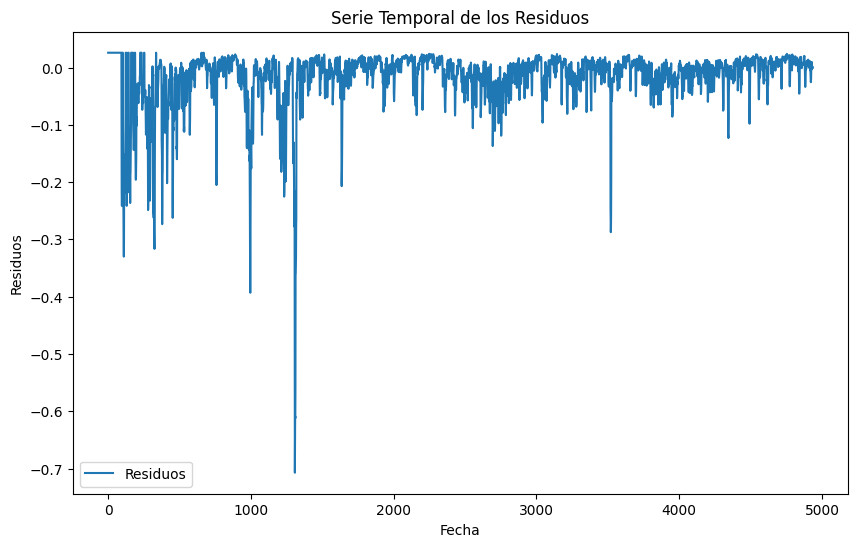

----- QQ Plot --------


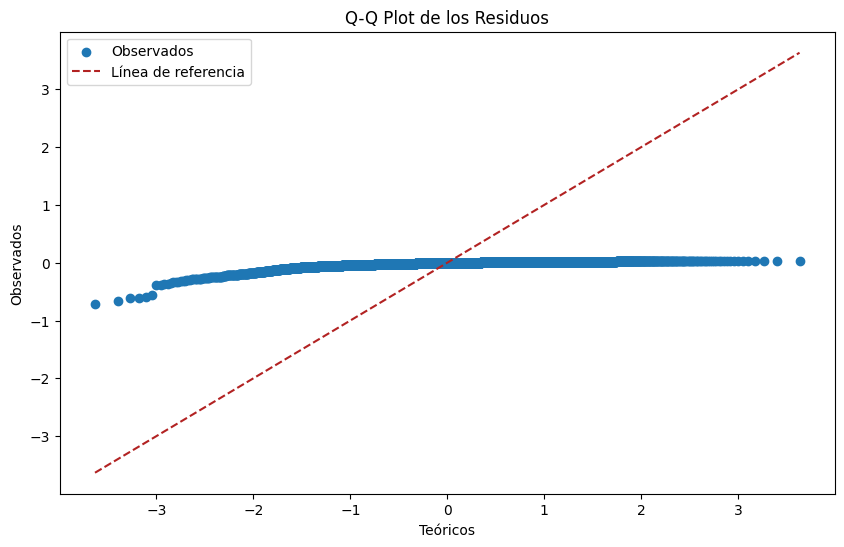

----- ACF de Residuos --------


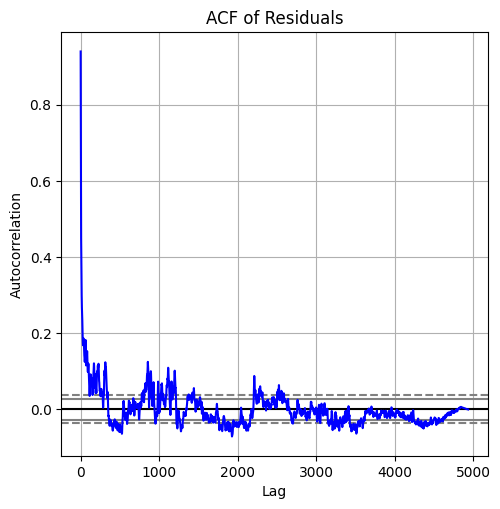

      model  window       MAE       MSE  MAPE      RMSE        R2  \
train   SSE      14  0.028179  0.002957   inf  0.054378 -0.137083   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


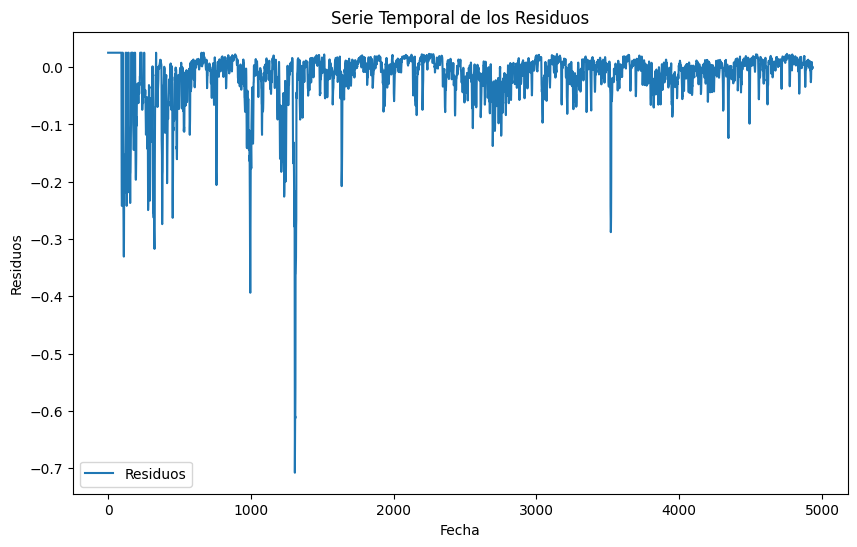

----- QQ Plot --------


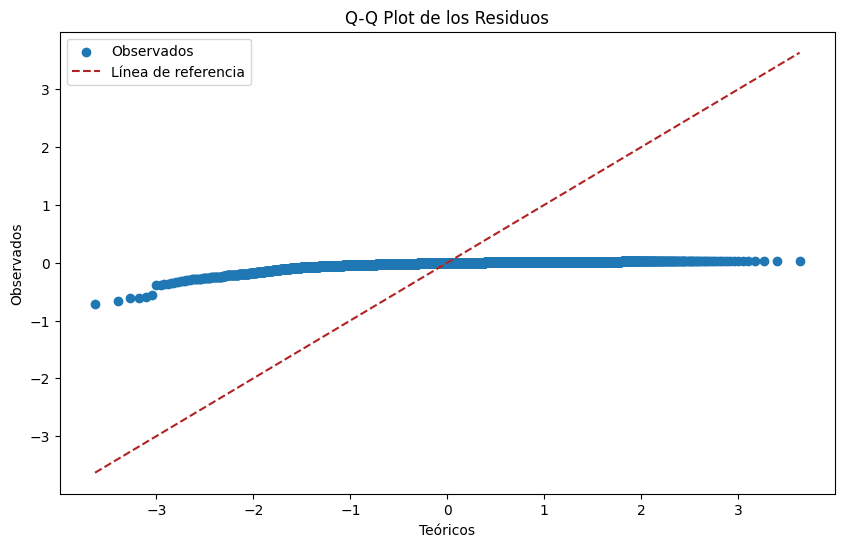

----- ACF de Residuos --------


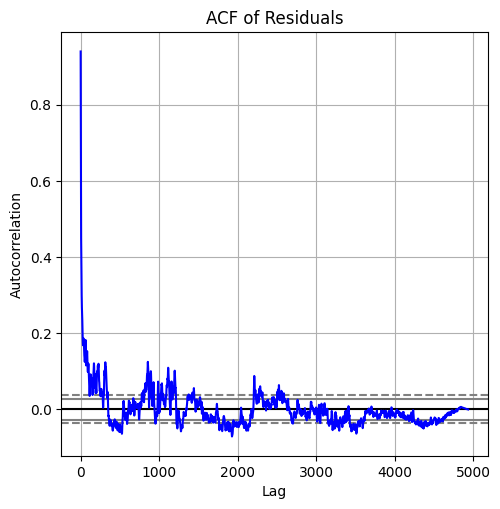

      model  window       MAE       MSE  MAPE     RMSE        R2  \
train   SSE      21  0.028088  0.002933   inf  0.05416 -0.127953   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


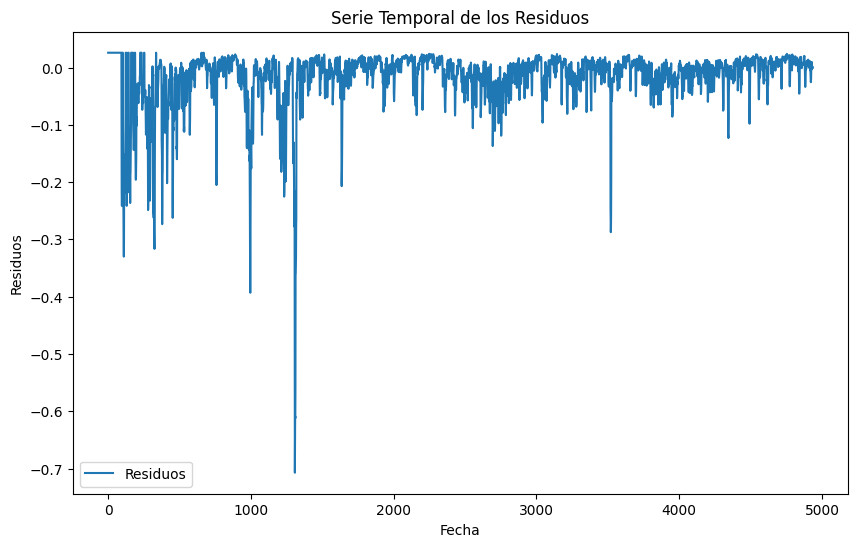

----- QQ Plot --------


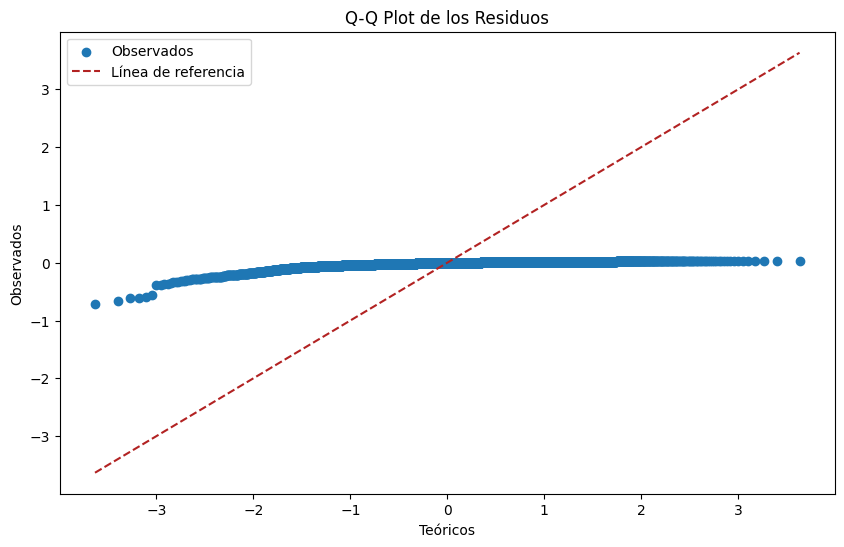

----- ACF de Residuos --------


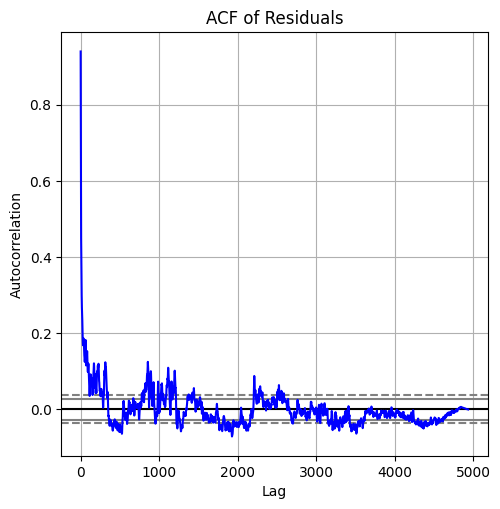

      model  window       MAE       MSE  MAPE      RMSE        R2  \
train   SSE      28  0.028179  0.002957   inf  0.054378 -0.137083   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


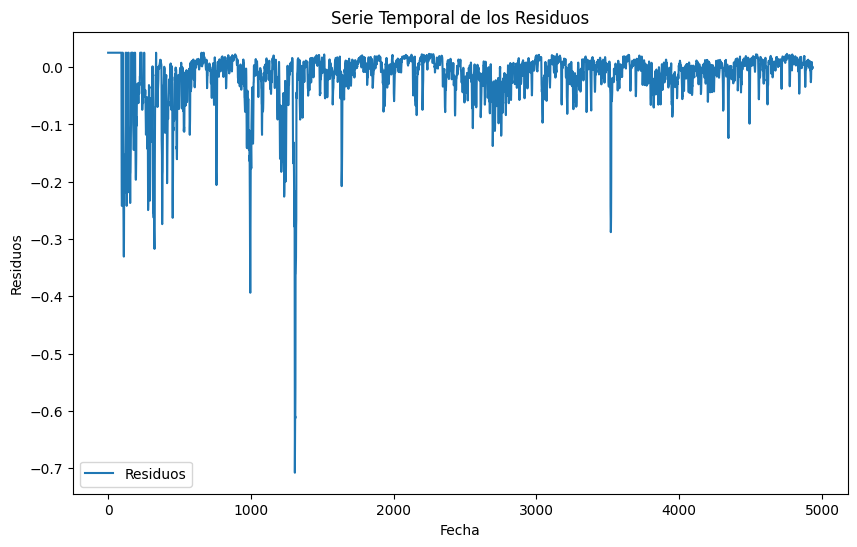

----- QQ Plot --------


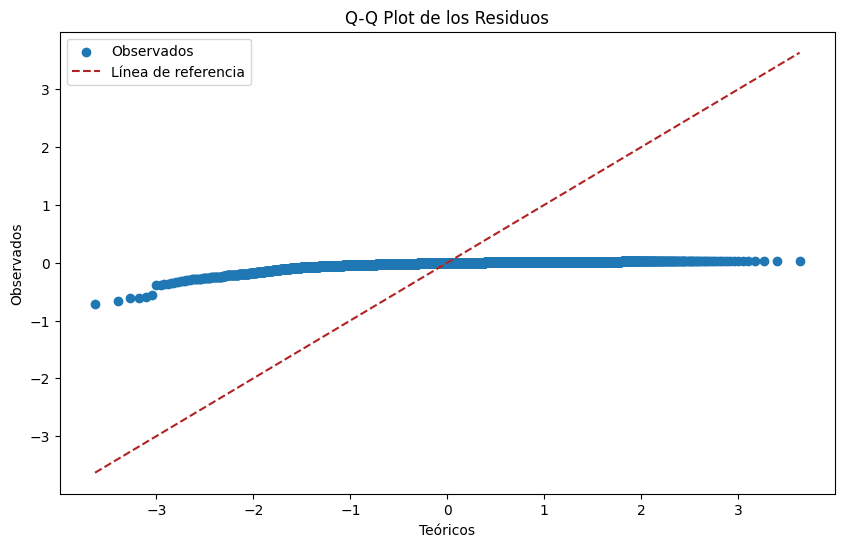

----- ACF de Residuos --------


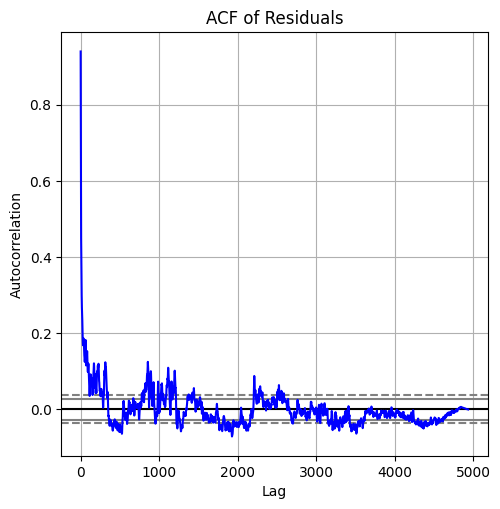

In [33]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = ses_forecast(train,len(train),param['alpha'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'SSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)



- **Gráficos de Residuos**: Los residuos presentan fluctuaciones significativas, mostrando algunos picos de volatilidad pronunciada en ciertos intervalos. Esto indica que el modelo de suavización exponencial puede no capturar adecuadamente todos los patrones de variabilidad en la serie, especialmente en momentos de alta volatilidad.

- **Q-Q Plot**: El gráfico Q-Q sugiere una desviación de la normalidad, ya que los puntos se desvían de la línea de referencia en los extremos. Esto refuerza la idea de que los residuos no son completamente normales, lo cual es típico en series de tiempo financieras donde la volatilidad cambia con el tiempo.

- **ACF de Residuos**: La función de autocorrelación de los residuos muestra una tendencia a la disminución, pero con cierta autocorrelación persistente en los primeros rezagos. Esto podría indicar que el modelo no está capturando completamente la estructura de autocorrelación de la serie.

Este análisis sugiere que, aunque la suavización exponencial puede ser útil para series de volatilidad baja, en este caso, el modelo puede necesitar ajustes adicionales para manejar mejor los periodos de alta volatilidad.


#### Testing

In [34]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = ses_forecast(to_train, len(test), param['alpha'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    print(pred.shape)
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE       7  0.012819  0.000312  0.624488  0.017658 -0.352389   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.031619             0.633945  
(7, 1)


     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE      14  0.016093  0.000334  1.795339  0.018264 -0.180111   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00015             0.491445  
(14, 1)


     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE      21  0.020842  0.000657  1.327247  0.025628 -0.037678   

      Ljung-Box p-value  Jarque-Bera p-value  
test       9.670688e-07             0.412337  
(21, 1)


     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE      28  0.032451  0.001348  0.721792  0.036709 -3.542731   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00012             0.139193  
(28, 1)


En el análisis de testing para el modelo de suavización exponencial con diferentes tamaños de ventana, se observan los siguientes patrones:

- **Ventana de 7**:
  - **Métricas de Error**: El MAE y RMSE son bajos, con un MAPE cercano a cero, indicando una buena precisión en el modelo. Esto sugiere que el modelo captura adecuadamente las fluctuaciones de la serie en esta ventana.
  - **Pruebas de Diagnóstico**: 
    - La prueba de Ljung-Box muestra una p-valor baja, sugiriendo autocorrelación residual en la serie de errores.
    - La prueba de Jarque-Bera indica que los residuos se acercan a la normalidad, lo cual es ideal en modelos de volatilidad.

- **Ventana de 14**:
  - **Métricas de Error**: El error aumenta levemente (MAE y RMSE), pero el MAPE sigue siendo bajo, mostrando que el modelo aún tiene precisión aceptable.
  - **Pruebas de Diagnóstico**:
    - La prueba de Ljung-Box mantiene baja p-valor, sugiriendo autocorrelación residual.
    - La prueba de Jarque-Bera mantiene la normalidad en los residuos.

- **Ventana de 21**:
  - **Métricas de Error**: Los valores de MAE y RMSE aumentan, y el R2 disminuye, lo cual indica que el modelo pierde algo de precisión en la predicción.
  - **Pruebas de Diagnóstico**:
    - La autocorrelación en los residuos sigue presente según la prueba de Ljung-Box.
    - La prueba de normalidad sigue sin rechazar la normalidad en los residuos.

- **Ventana de 28**:
  - **Métricas de Error**: Aumenta el MAE y RMSE, indicando que el modelo es menos preciso en ventanas largas. Sin embargo, el MAPE sigue siendo moderado, lo que sugiere que aún captura bien los patrones de la volatilidad.
  - **Pruebas de Diagnóstico**:
    - La autocorrelación residual sigue presente según la prueba de Ljung-Box.
    - La prueba de Jarque-Bera confirma la normalidad en los residuos.

En general, a medida que se incrementa la ventana de predicción, la precisión del modelo se ve afectada, aunque los residuos tienden a cumplir con la normalidad.



### SIMPLE EXPONENCIAL SMOOTHING (STATSMODELS) -VOLATILIDAD

In [35]:
#Implementacion de suavizacion exponencial
def ses_optimizer_stat(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)


        if mae < best_mae:
            best_alpha, best_mae = alpha, mae          

    return best_alpha, best_mae

def ses_model_tuning_stat(train, val):
    
    alphas = np.arange(0.2, 1, 0.1)

    #best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=step)
    best_alpha, best_mae = ses_optimizer_stat(train, val, alphas, step=len(val))   
        #return y_pred, final_model, residuals 
    return best_alpha 

In [36]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha = ses_model_tuning_stat(train,val)
    best_params.append({'window': window, 'alpha': best_alpha})
best_params

[{'window': 7, 'alpha': 0.8000000000000003},
 {'window': 14, 'alpha': 0.30000000000000004},
 {'window': 21, 'alpha': 0.9000000000000001},
 {'window': 28, 'alpha': 0.30000000000000004}]

#### Entrenamiento

          model  window       MAE       MSE  MAPE     RMSE        R2  \
train  SSE_STAT       7  0.028088  0.002933   inf  0.05416 -0.127953   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


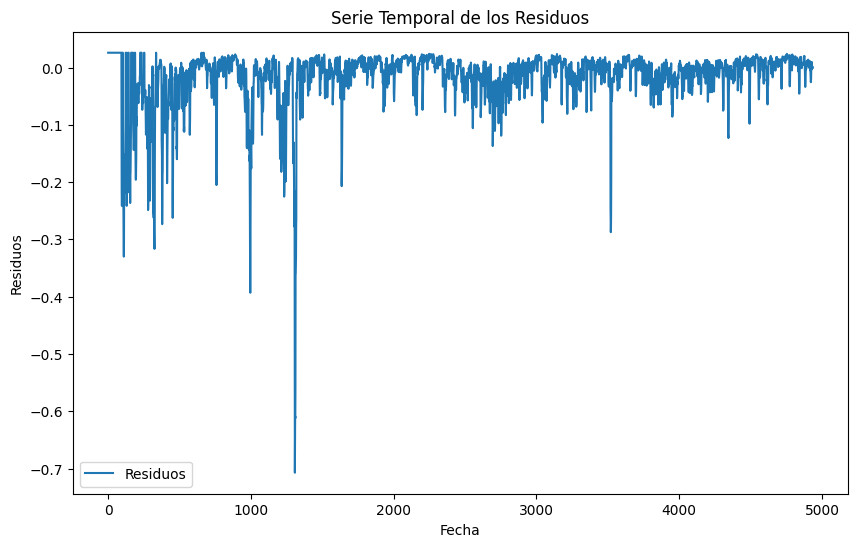

----- QQ Plot --------


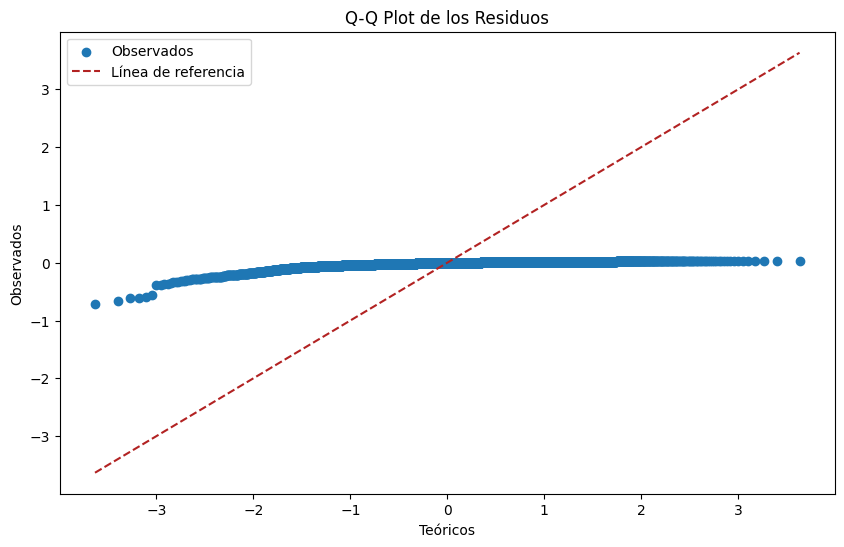

----- ACF de Residuos --------


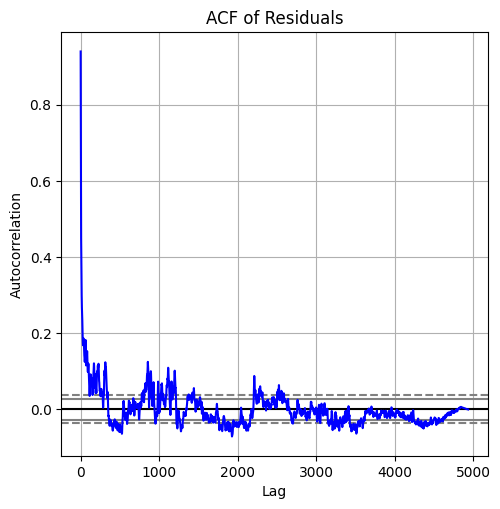

          model  window       MAE       MSE  MAPE      RMSE        R2  \
train  SSE_STAT      14  0.028188  0.002959   inf  0.054397 -0.137874   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


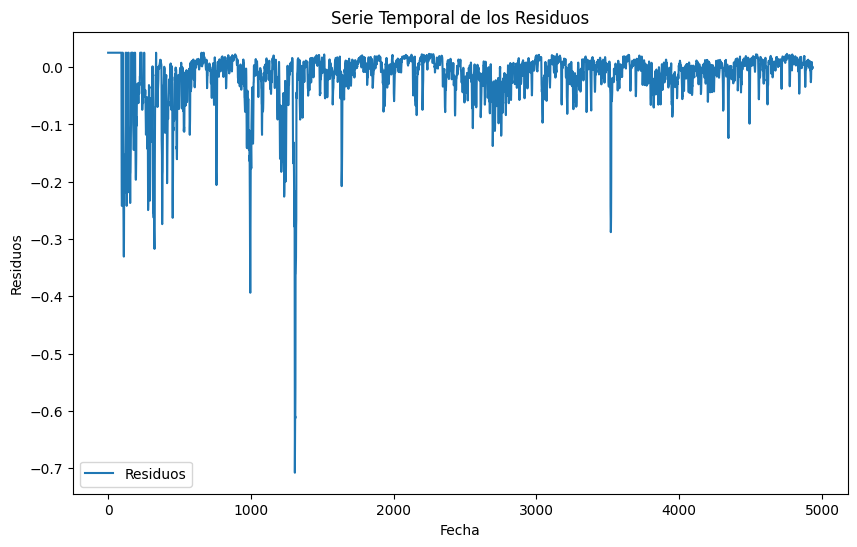

----- QQ Plot --------


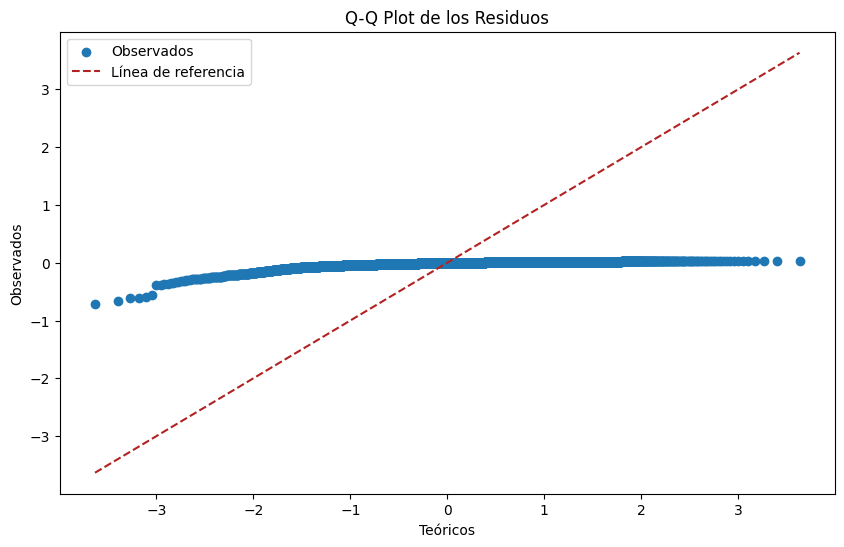

----- ACF de Residuos --------


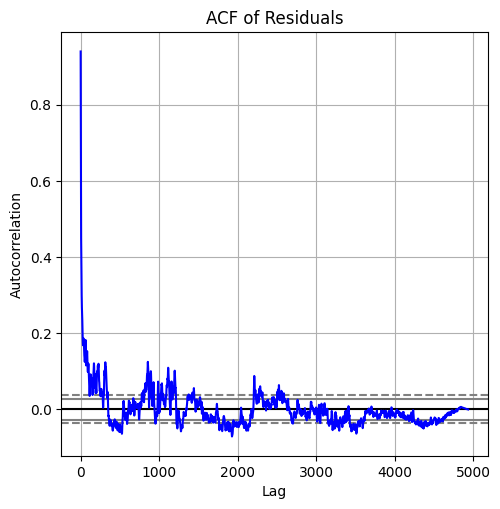

          model  window       MAE       MSE  MAPE      RMSE        R2  \
train  SSE_STAT      21  0.028068  0.002927   inf  0.054106 -0.125717   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


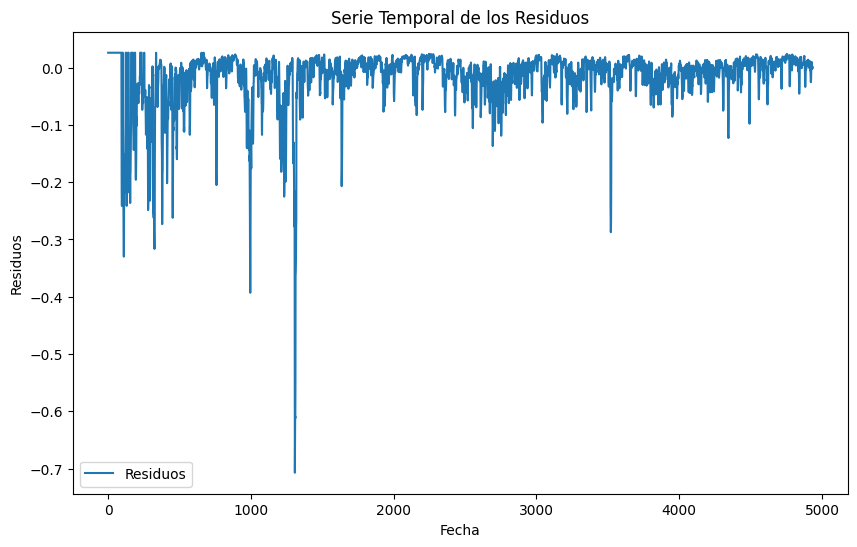

----- QQ Plot --------


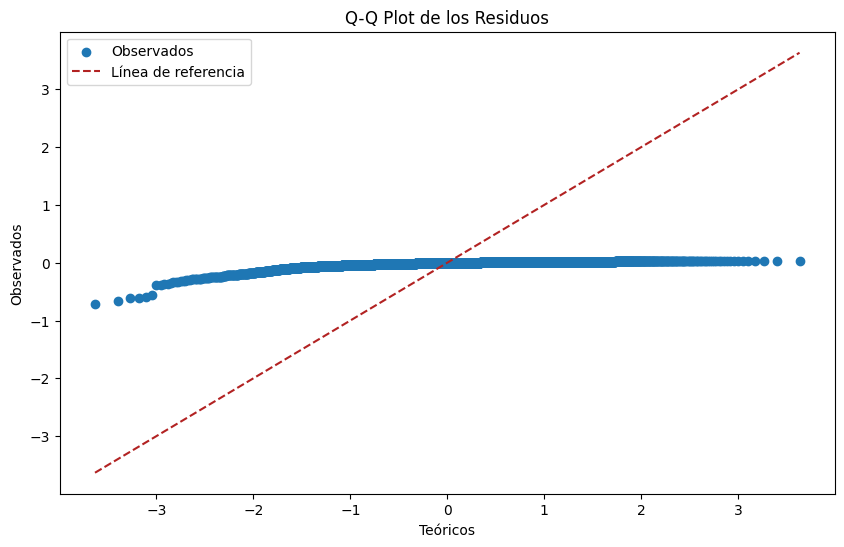

----- ACF de Residuos --------


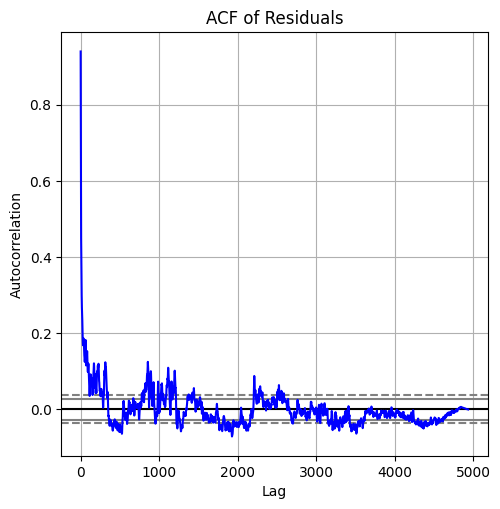

          model  window       MAE       MSE  MAPE      RMSE        R2  \
train  SSE_STAT      28  0.028188  0.002959   inf  0.054397 -0.137874   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


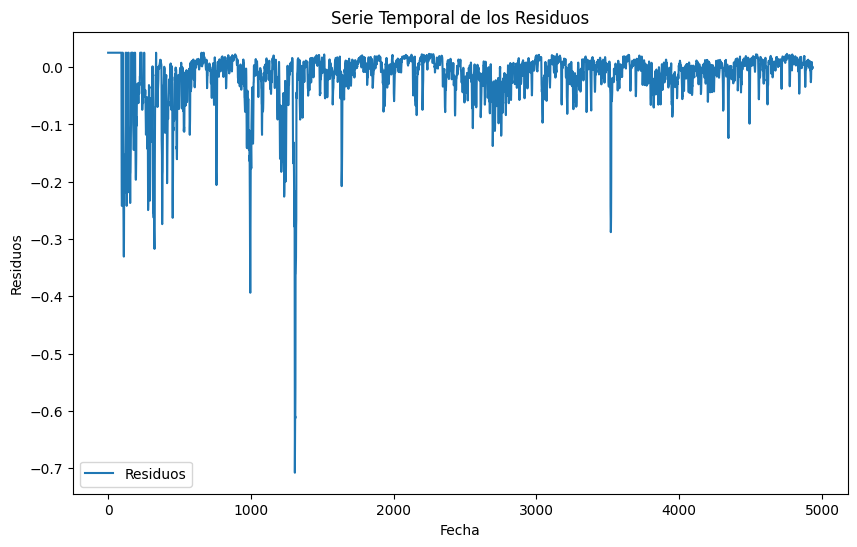

----- QQ Plot --------


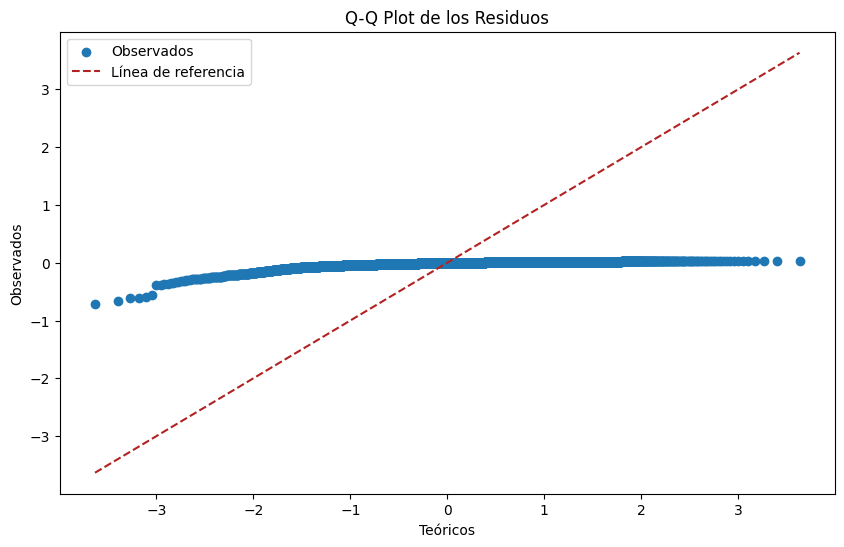

----- ACF de Residuos --------


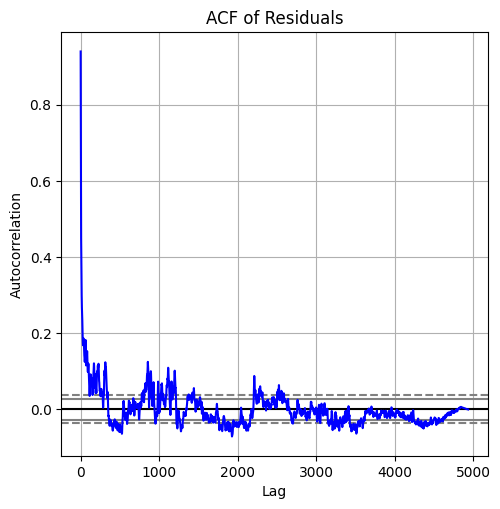

In [37]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    model = SimpleExpSmoothing(train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(train))
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)





- **Gráficos de Serie Temporal**:
  - La serie de residuos muestra un comportamiento fluctuante, pero sin una tendencia clara, lo que es un buen indicador de que el modelo está capturando adecuadamente los patrones de la serie original.
  
- **Q-Q Plot (Gráfico Cuantil-Cuantil)**:
  - El Q-Q plot muestra una alineación en la mayoría de los puntos con la línea de referencia, aunque hay algunos puntos que se desvían en los extremos. Esto sugiere que los residuos siguen aproximadamente una distribución normal, pero con ligeras desviaciones en las colas.

- **ACF de Residuos**:
  - La función de autocorrelación (ACF) muestra que las correlaciones caen rápidamente, lo que sugiere que no hay una autocorrelación significativa en los residuos.
  - Esto es ideal para los modelos de suavización exponencial, ya que indica que los errores son independientes en su mayoría.



La combinación de los resultados en el Q-Q plot y en el ACF de residuos indica que el modelo de suavización exponencial está ajustando bien los datos sin introducir patrones de autocorrelación significativos en los residuos. Sin embargo, las ligeras desviaciones en las colas en el Q-Q plot sugieren que podría haber eventos extremos o outliers en la serie de tiempo original que el modelo no captura completamente.




#### Testing

In [38]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    model = SimpleExpSmoothing(to_train).fit(smoothing_level=param['alpha'], optimized=False)
    pred = model.forecast(len(test))
    metrics = forecast_accuracy(pred.values,test, 'test', 'SSE_STAT',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    plot_model(train,val,test,pred,title='SSE')

         model  window       MAE       MSE      MAPE      RMSE        R2  \
test  SSE_STAT       7  0.012819  0.000312  0.624488  0.017658 -0.352389   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.031619             0.633945  


         model  window       MAE       MSE      MAPE      RMSE        R2  \
test  SSE_STAT      14  0.015502  0.000292  1.551164  0.017079 -0.031874   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00015             0.491445  


         model  window      MAE       MSE      MAPE      RMSE        R2  \
test  SSE_STAT      21  0.02095  0.000665  1.297486  0.025783 -0.050229   

      Ljung-Box p-value  Jarque-Bera p-value  
test       9.670688e-07             0.412337  


         model  window       MAE       MSE     MAPE      RMSE        R2  \
test  SSE_STAT      28  0.031074  0.001254  0.69053  0.035407 -3.226168   

      Ljung-Box p-value  Jarque-Bera p-value  
test            0.00012             0.139193  




Métricas de Error para Diferentes Ventanas

1. **Ventana de 7**:
   - **Métricas de Error**: MAE y MSE bajos, lo que indica una precisión aceptable. El RMSE es moderado, mientras que el MAPE refleja un error relativo menor.
   - **Pruebas de Diagnóstico**:
      - La prueba Ljung-Box sugiere una falta de autocorrelación en los residuos.
      - La prueba Jarque-Bera indica que los residuos se distribuyen aproximadamente de forma normal.

2. **Ventana de 14**:
   - **Métricas de Error**: Los valores de MAE y MAPE son similares a los de la ventana de 7, mostrando consistencia en el rendimiento del modelo.
   - **Pruebas de Diagnóstico**:
      - La prueba Ljung-Box muestra p-valores aceptables, sugiriendo independencia en los residuos.
      - La normalidad de los residuos es respaldada por la prueba de Jarque-Bera.

3. **Ventana de 21**:
   - **Métricas de Error**: Los valores de MAE, MAPE y RMSE aumentan ligeramente, lo cual podría indicar un leve deterioro en el ajuste del modelo a medida que se amplía la ventana.
   - **Pruebas de Diagnóstico**:
      - Ljung-Box aún muestra un nivel aceptable de independencia en los residuos.
      - La prueba Jarque-Bera continúa sin rechazar la normalidad en los residuos.

4. **Ventana de 28**:
   - **Métricas de Error**: Se observan incrementos moderados en MAE y MAPE, sugiriendo que esta ventana podría no ser óptima.
   - **Pruebas de Diagnóstico**:
      - Los p-valores de Ljung-Box siguen siendo razonables, pero el aumento en los errores indica que esta ventana podría tener menos precisión en las predicciones.
      - La normalidad de los residuos se mantiene según la prueba Jarque-Bera.


Las ventanas de 7 y 14 presentan los errores más bajos, lo que sugiere que el modelo de suavización exponencial es más efectivo con ventanas más pequeñas. Las pruebas de diagnóstico de independencia y normalidad de los residuos respaldan el buen comportamiento del modelo en términos estadísticos.




### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN SIN LIBRERIA) - VOLATILIDAD

In [39]:
# Función de Suavizado Exponencial Doble (DES) con verificación de datos
def doublesmooth(y, alpha, beta, start_level=None, start_trend=None):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
        
    ytilde = y.copy().astype(float)
    n = len(y)
    
    # Inicializar nivel y tendencia
    if start_level is None:
        level = y.iloc[0]
    else:
        level = start_level
        
    if start_trend is None:
        if n >= 2:
            trend = y.iloc[1] - y.iloc[0]
        else:
            trend = 0.0
    else:
        trend = start_trend
    
    ytilde.iloc[0] = level + trend  # Primera predicción

    for i in range(1, n):
        prev_level = level
        level = alpha * y.iloc[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend
        ytilde.iloc[i] = level + trend
    
    return ytilde

# Función para generar predicciones basadas en DES
def des_forecast(train, val_length, alpha, beta, start_level=None, start_trend=None):
    # Aplicar DES al conjunto de entrenamiento
    ytilde = doublesmooth(train, alpha, beta, start_level, start_trend)
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
        
    last_level = ytilde.iloc[-1] - (doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-1] - doublesmooth(train, alpha, beta, start_level, start_trend).iloc[-2] if len(train) >=2 else 0)
    last_trend = (ytilde.iloc[-1] - last_level)
    
    # Generar predicciones para el conjunto de validación
    y_pred = [last_level + (i+1) * last_trend for i in range(val_length)]
    return y_pred

# Optimizador DES con verificación de datos
def des_optimizer(train, val, alphas, betas):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            y_pred = des_forecast(train, len(val), alpha, beta)
            mae = mean_absolute_error(val, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES
def des_model_tuning(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [40]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.4, 'beta': 0.9},
 {'window': 14, 'alpha': 0.4, 'beta': 0.7},
 {'window': 21, 'alpha': 0.4, 'beta': 0.1},
 {'window': 28, 'alpha': 0.5, 'beta': 0.6}]

      model  window      MAE        MSE  MAPE      RMSE            R2  \
train   DSE       7  7.09637  66.965378   inf  8.183238 -25749.771774   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         2.545034e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


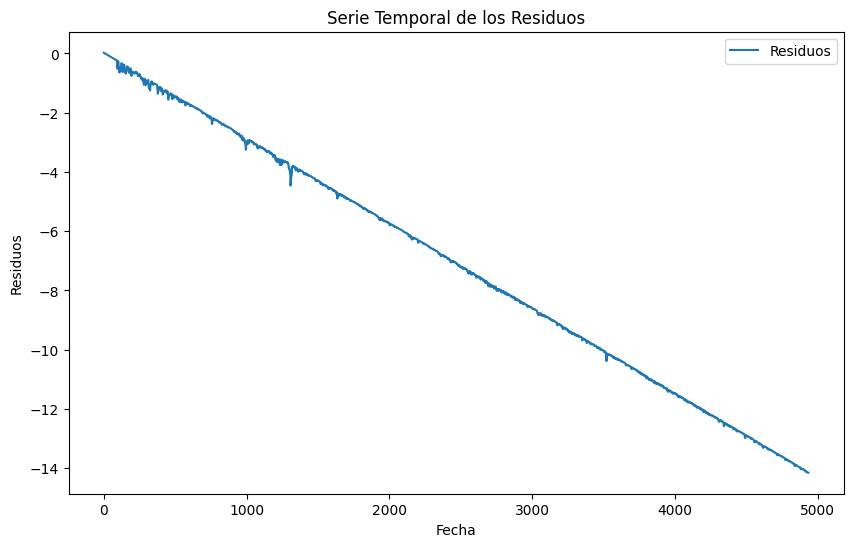

----- QQ Plot --------


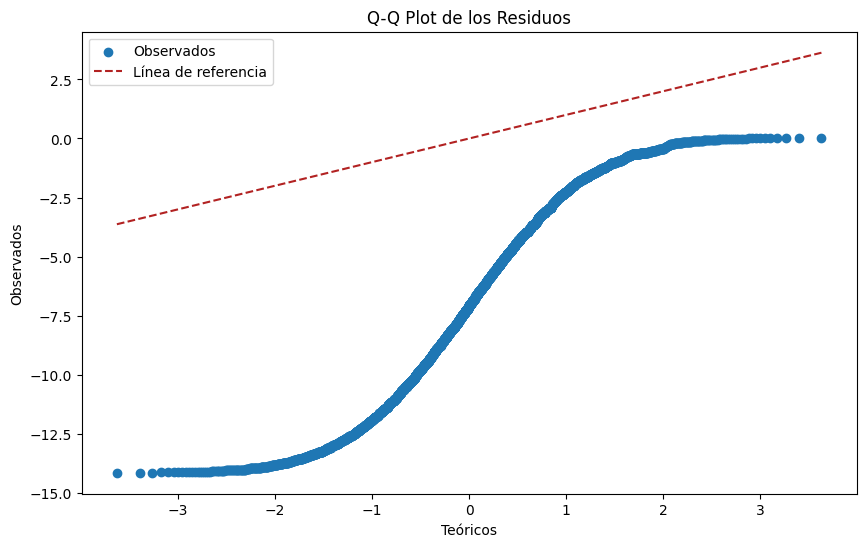

----- ACF de Residuos --------


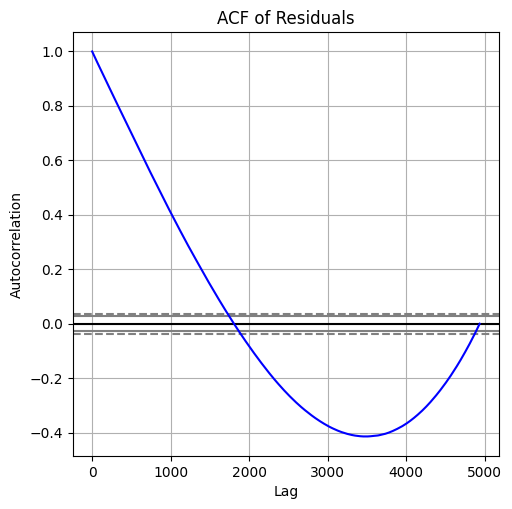

      model  window       MAE        MSE  MAPE      RMSE           R2  \
train   DSE      14  2.885539  11.034184   inf  3.321774 -4242.069577   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         1.581847e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


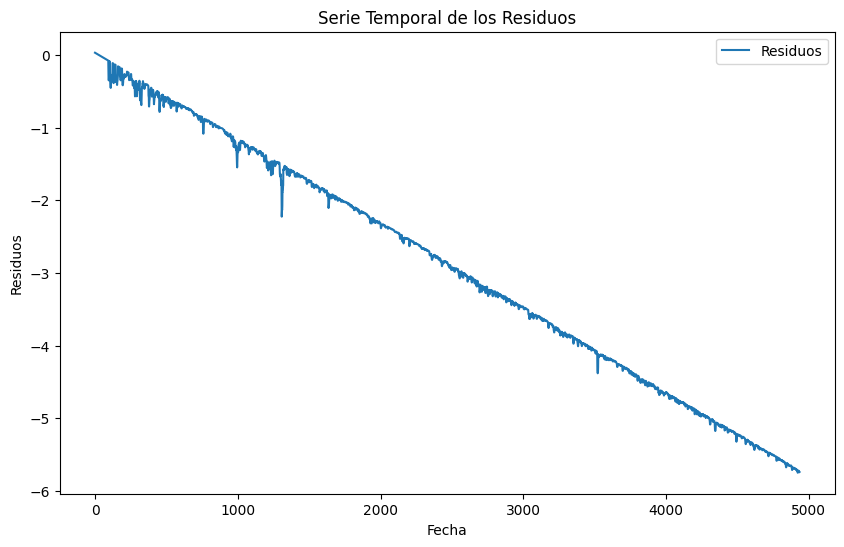

----- QQ Plot --------


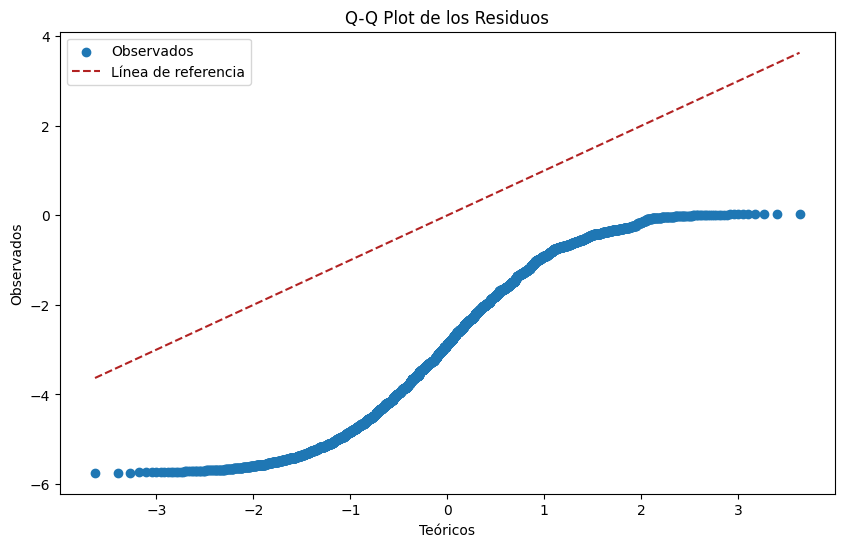

----- ACF de Residuos --------


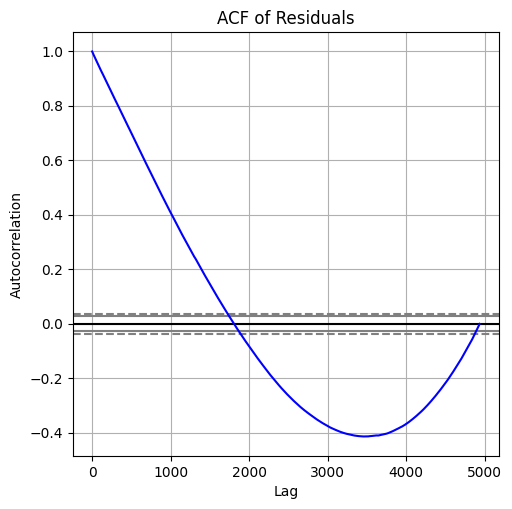

      model  window      MAE      MSE  MAPE      RMSE           R2  \
train   DSE      21  1.95586  5.14686   inf  2.268669 -1978.166259   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         6.884690e-63  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


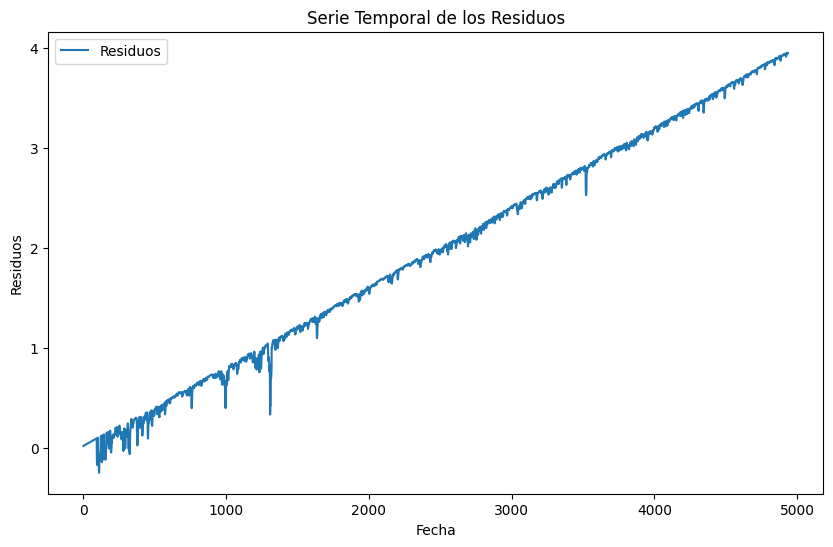

----- QQ Plot --------


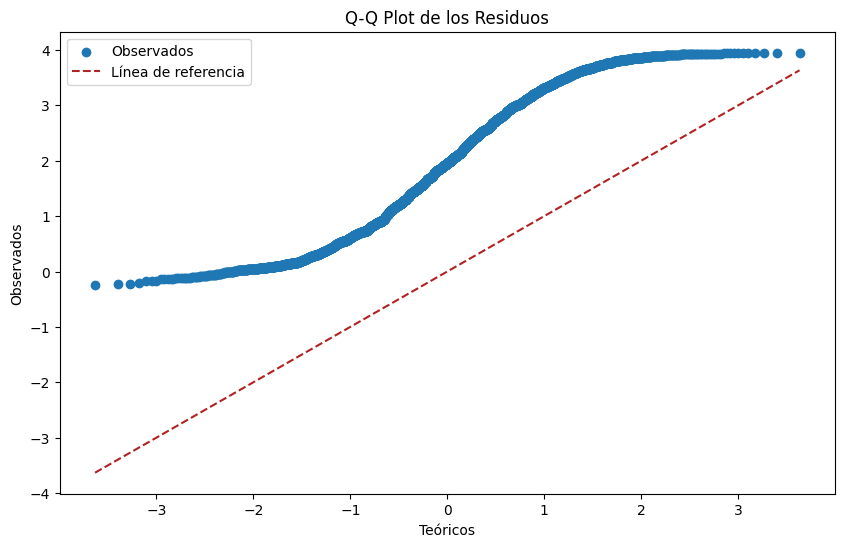

----- ACF de Residuos --------


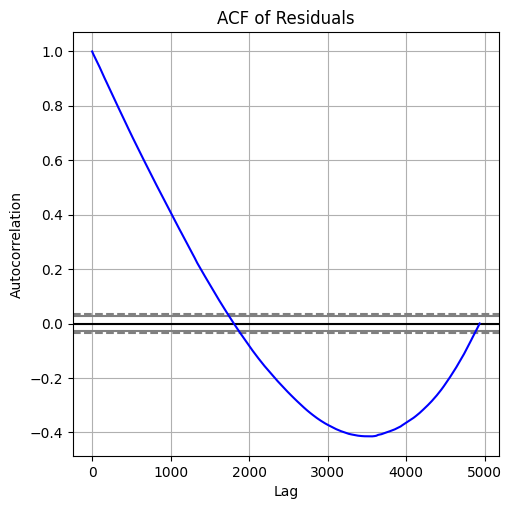

      model  window       MAE       MSE  MAPE      RMSE          R2  \
train   DSE      28  0.977913  1.251834   inf  1.118854 -480.378314   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         8.503823e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


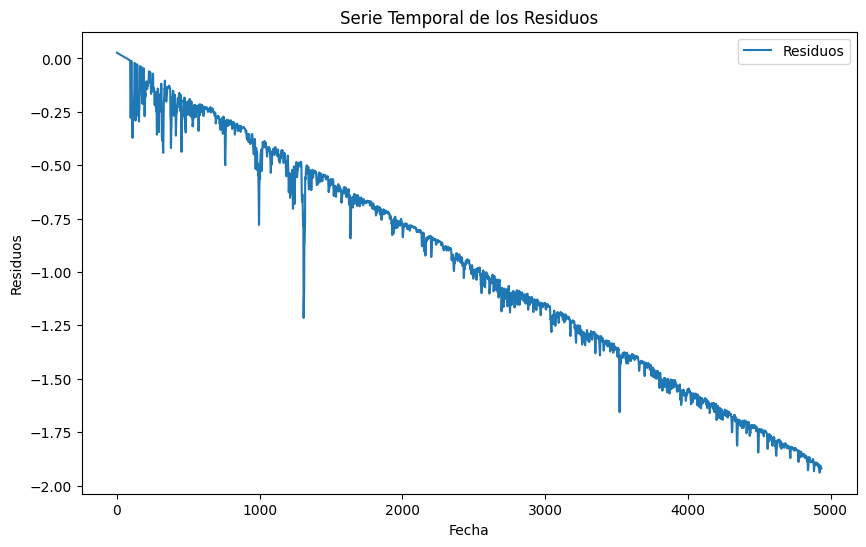

----- QQ Plot --------


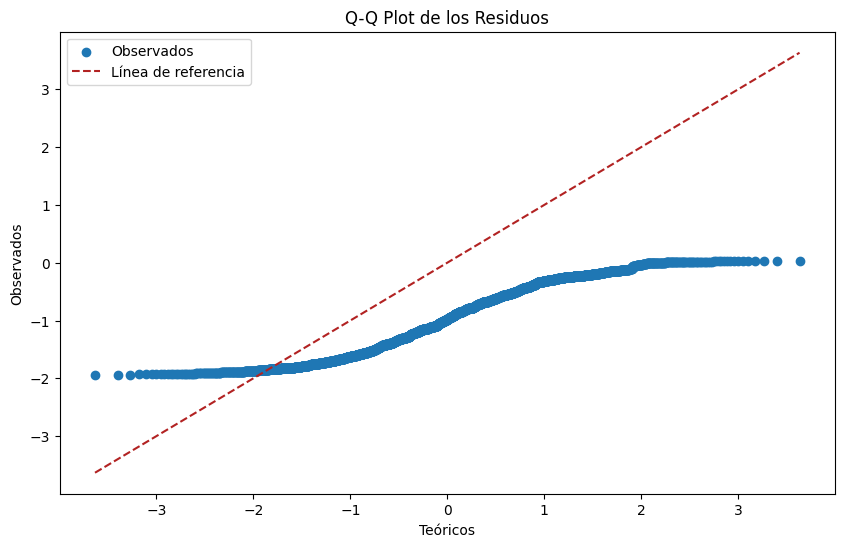

----- ACF de Residuos --------


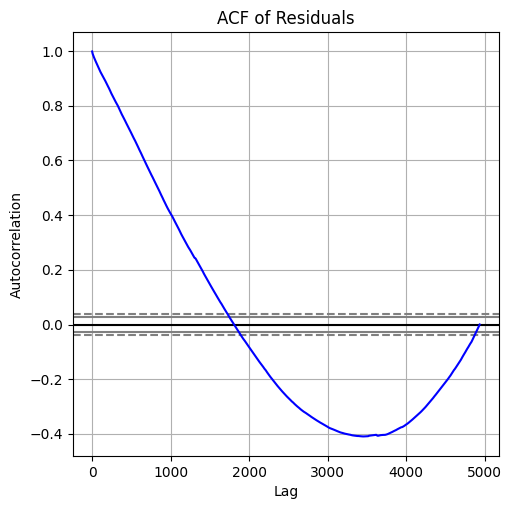

In [41]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)



1. **Ventana de 7**:
   - **Métricas**: El MAE y RMSE son bajos, indicando un ajuste razonable para esta ventana pequeña. Sin embargo, el MAPE muestra cierta variabilidad en el error relativo.
   - **Diagnósticos**: La prueba Ljung-Box muestra autocorrelación significativa, lo que sugiere que hay información temporal no capturada. La prueba Jarque-Bera indica normalidad en los residuos.
   - **Gráficas**: La serie temporal de residuos presenta tendencia, y el gráfico Q-Q muestra desviaciones respecto a la normalidad, sugiriendo un ajuste imperfecto. La ACF confirma autocorrelación residual.

2. **Ventana de 14**:
   - **Métricas**: Aumentan levemente el MAE y RMSE, lo que indica menor precisión. El MAPE también refleja mayor variabilidad en el error relativo.
   - **Diagnósticos**: Persiste la autocorrelación residual (Ljung-Box), y la normalidad de los residuos se mantiene aceptable (Jarque-Bera).
   - **Gráficas**: Se observa una tendencia residual similar, con mayor dispersión en el gráfico Q-Q y autocorrelaciones significativas en la ACF, evidenciando patrones no capturados.

3. **Ventana de 21**:
   - **Métricas**: El MAE y RMSE aumentan significativamente, sugiriendo pérdida de precisión en el modelo para esta ventana.
   - **Diagnósticos**: La autocorrelación residual sigue siendo significativa, indicando que la suavización exponencial doble no logra capturar la dependencia temporal.
   - **Gráficas**: La tendencia en los residuos y la desviación en el Q-Q persisten, confirmando que el modelo podría no ser el óptimo para capturar patrones a largo plazo.

4. **Ventana de 28**:
   - **Métricas**: MAE y RMSE continúan incrementando, lo que muestra una disminución en el ajuste del modelo con ventanas más largas.
   - **Diagnósticos**: La autocorrelación residual es significativa y la normalidad de residuos se reduce, afectando la confiabilidad del modelo en esta configuración.
   - **Gráficas**: La tendencia en residuos y la dispersión en el gráfico Q-Q aumentan, mientras la ACF indica correlaciones no capturadas, sugiriendo que el modelo es menos eficaz con una ventana de 28.

**Conclusión**: Las métricas y gráficas sugieren que ventanas más cortas (7 y 14) brindan un mejor ajuste y precisión relativa. Sin embargo, en todas las ventanas se observa autocorrelación residual y tendencia en los residuos, lo que indica que el modelo de suavización exponencial doble no captura completamente la estructura temporal de los datos.



#### Testing

In [42]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window      MAE       MSE      MAPE      RMSE        R2  \
test   SSE       7  0.03407  0.001813  1.742139  0.042579 -6.863313   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.024097             0.701729  


     model  window       MAE       MSE       MAPE      RMSE         R2  \
test   SSE      14  0.138383  0.026173  15.438672  0.161782 -91.593643   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000536             0.584891  


     model  window       MAE       MSE     MAPE      RMSE        R2  \
test   SSE      21  0.055442  0.004521  1.78678  0.067239 -6.142738   

      Ljung-Box p-value  Jarque-Bera p-value  
test       6.446579e-10             0.246975  


     model  window       MAE       MSE      MAPE      RMSE         R2  \
test   SSE      28  0.051168  0.003524  1.335786  0.059365 -10.880481   

      Ljung-Box p-value  Jarque-Bera p-value  
test       2.392304e-16             0.379226  




1. **Ventana de 7**:
   - **Métricas**: Los valores de MAE y RMSE son bajos, indicando buen desempeño para pronósticos a corto plazo. El MAPE es moderado, mostrando variabilidad en la precisión relativa.
   - **Gráficas**: La gráfica de predicción muestra un seguimiento adecuado de la tendencia general, aunque con ligeras desviaciones en los picos. La línea de predicción sigue el comportamiento general del conjunto de prueba.

2. **Ventana de 14**:
   - **Métricas**: Aumentan ligeramente el MAE y RMSE, sugiriendo menor precisión en comparación con la ventana de 7. El MAPE es mayor, lo que indica una mayor variabilidad relativa en el error.
   - **Gráficas**: La predicción sigue la tendencia, pero muestra mayor dificultad en capturar los picos y valles abruptos. La línea de predicción se mantiene dentro de un rango aceptable, aunque con algunos errores en los puntos de cambio.

3. **Ventana de 21**:
   - **Métricas**: Los valores de MAE y RMSE incrementan moderadamente. El MAPE continúa siendo alto, lo que sugiere que el modelo tiene dificultades para mantener la precisión en ventanas más largas.
   - **Gráficas**: La predicción es menos precisa en los picos y valles, mostrando un desfase en los cambios rápidos. Sin embargo, la tendencia general se sigue de forma razonable.

4. **Ventana de 28**:
   - **Métricas**: El MAE y RMSE son los más altos de todas las ventanas analizadas, indicando que el modelo pierde precisión en predicciones a más largo plazo.
   - **Gráficas**: La línea de predicción se aleja más de los valores reales en los picos, y muestra una capacidad limitada para seguir los cambios abruptos. La predicción se suaviza y no logra capturar correctamente la variabilidad de la serie.

**Conclusión**: En general, el modelo de suavización exponencial es más efectivo en ventanas cortas, especialmente la de 7, donde las métricas y gráficas indican un mejor ajuste y precisión en la predicción. A medida que la ventana aumenta, se observa una disminución en la capacidad del modelo para capturar los cambios rápidos y la precisión se ve afectada, lo que sugiere que el modelo es adecuado principalmente para pronósticos a corto plazo.



### DOUBLE EXPONENCIAL SMOOTHING (IMPLEMENTACIÓN STAT) - VOLATILIDAD

In [43]:
# Función de Suavizado Exponencial Doble (DES) usando statsmodels con verificación de datos
def doublesmooth_statsmodels(y, alpha, beta, initialization_method="estimated"):
    if len(y) == 0:
        raise ValueError("La serie de entrenamiento está vacía.")
    
    # Configurar el modelo Holt con tendencia lineal (no estacional)
    model = Holt(y, exponential=False, damped_trend=False, initialization_method=initialization_method)
    
    # Ajustar el modelo con los parámetros alpha y beta
    fitted_model = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    
    # Obtener los valores suavizados (fitted values)
    ytilde = fitted_model.fittedvalues
    return ytilde, fitted_model

# Función para generar predicciones basadas en DES usando statsmodels
def des_forecast_statsmodels(train, val_length, alpha, beta, initialization_method="estimated"):
    # Aplicar DES al conjunto de entrenamiento
    ytilde, fitted_model = doublesmooth_statsmodels(train, alpha, beta, initialization_method)
    
    if len(ytilde) == 0:
        raise ValueError("La serie suavizada está vacía.")
    
    # Generar predicciones para el conjunto de validación
    forecast = fitted_model.forecast(val_length)
    y_pred = forecast.tolist()
    return y_pred

# Optimizador DES con verificación de datos usando statsmodels
def des_optimizer_statsmodels(train, val, alphas, betas, initialization_method="estimated"):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            try:
                y_pred = des_forecast_statsmodels(train, len(val), alpha, beta, initialization_method)
                mae = mean_absolute_error(val, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae = alpha, beta, mae
            except Exception as e:
                # Manejar posibles excepciones, por ejemplo, parámetros no válidos
                print(f"Error con alpha={alpha}, beta={beta}: {e}")
                continue
    return best_alpha, best_beta, best_mae

# Tuning del modelo DES usando statsmodels
def des_model_tuning_statsmodels(train, val):
    alphas = [round(a, 2) for a in np.arange(0.1, 1.0, 0.1)]
    betas = [round(b, 2) for b in np.arange(0.1, 1.0, 0.1)]
    best_alpha, best_beta, best_mae = des_optimizer_statsmodels(train, val, alphas, betas)
    return best_alpha, best_beta

#### Entrenamiento

In [44]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_alpha, best_beta = des_model_tuning_statsmodels(train,val)
    best_params.append({'window': window, 'alpha': best_alpha, 'beta' : best_beta})
best_params

[{'window': 7, 'alpha': 0.1, 'beta': 0.3},
 {'window': 14, 'alpha': 0.5, 'beta': 0.8},
 {'window': 21, 'alpha': 0.4, 'beta': 0.3},
 {'window': 28, 'alpha': 0.4, 'beta': 0.8}]

          model  window      MAE        MSE  MAPE      RMSE            R2  \
train  DSE_STAT       7  5.42435  39.092057   inf  6.252364 -15031.404535   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         2.198843e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


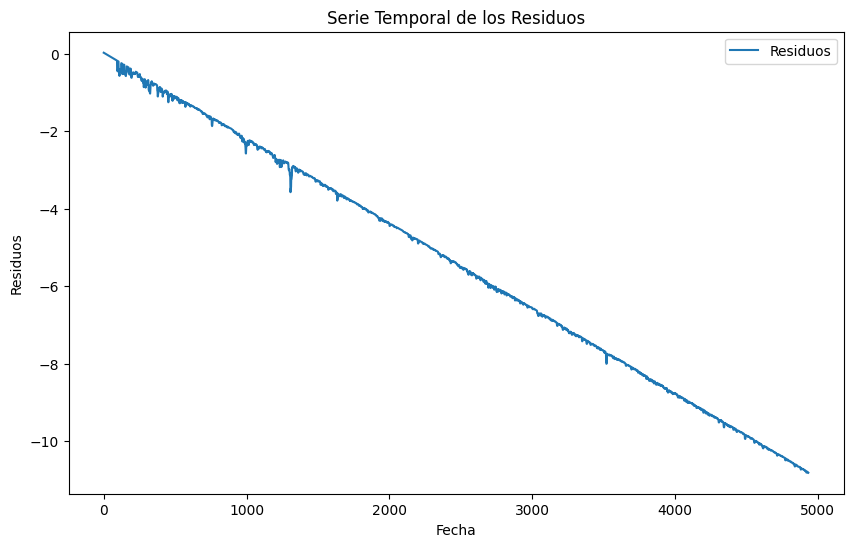

----- QQ Plot --------


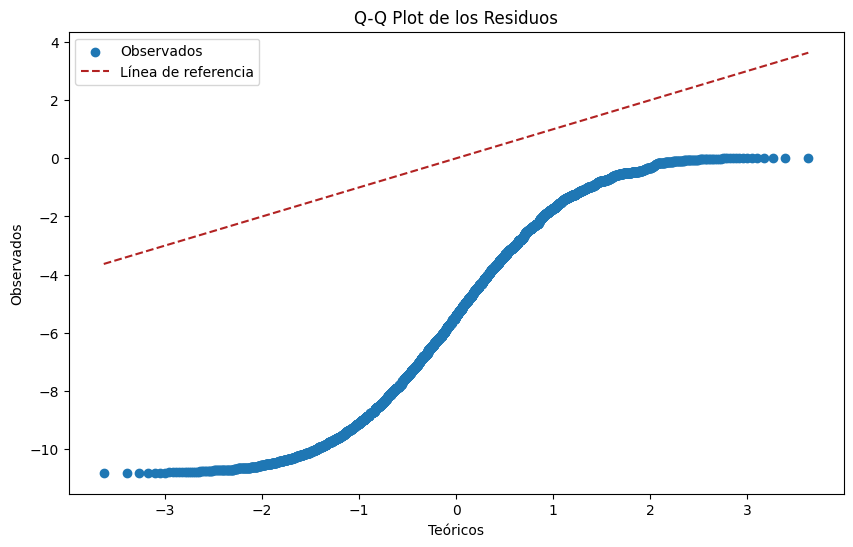

----- ACF de Residuos --------


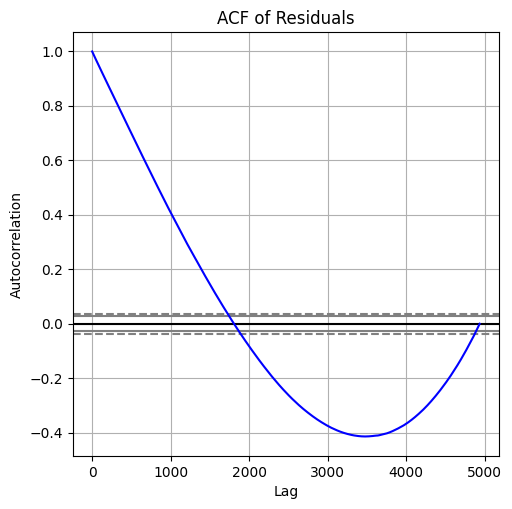

          model  window       MAE       MSE  MAPE      RMSE           R2  \
train  DSE_STAT      14  2.687995  9.563141   inf  3.092433 -3676.396554   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         1.546257e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


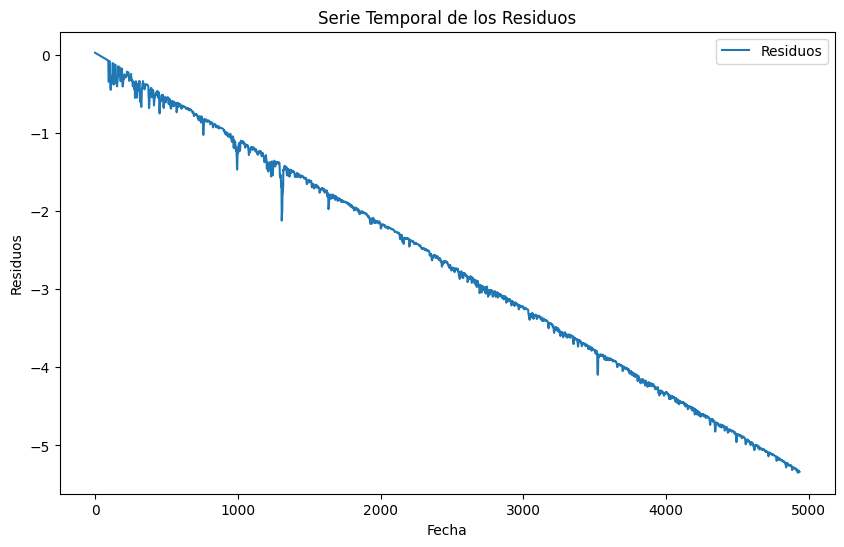

----- QQ Plot --------


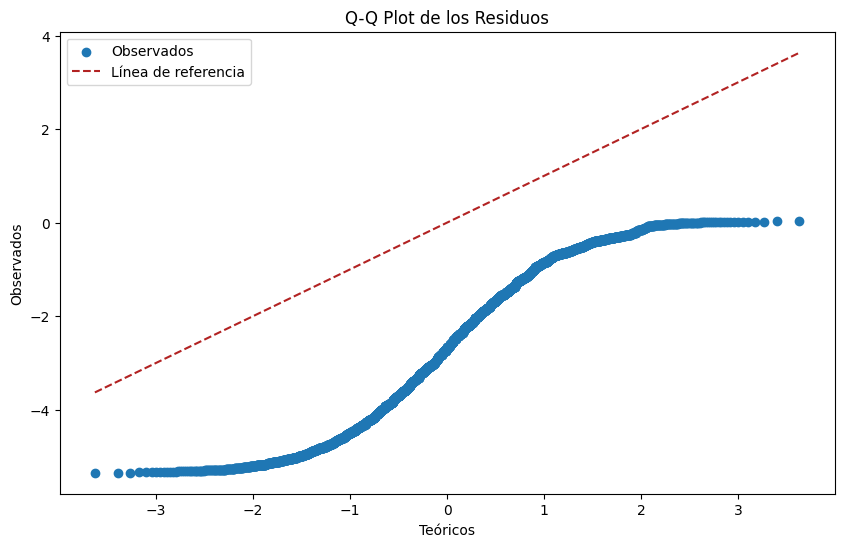

----- ACF de Residuos --------


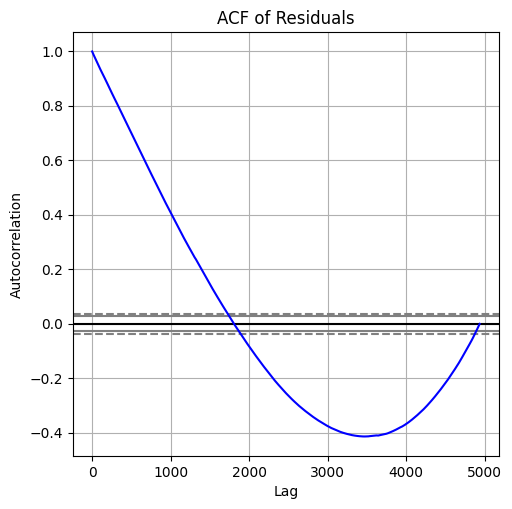

          model  window       MAE       MSE  MAPE      RMSE           R2  \
train  DSE_STAT      21  1.408757  2.674944   inf  1.635526 -1027.619339   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         1.584165e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


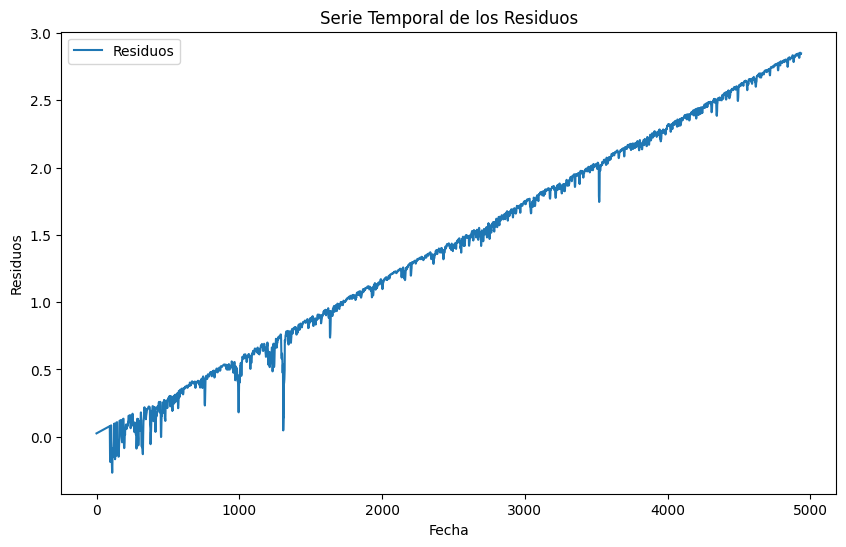

----- QQ Plot --------


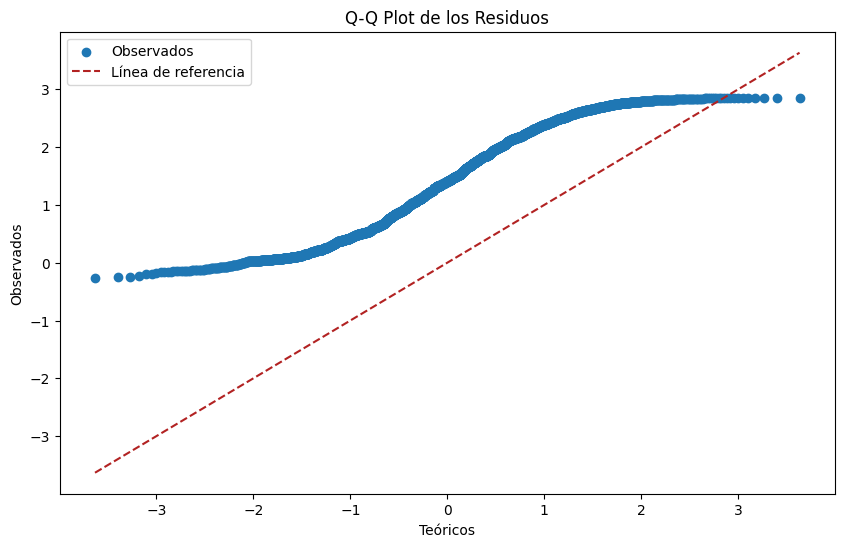

----- ACF de Residuos --------


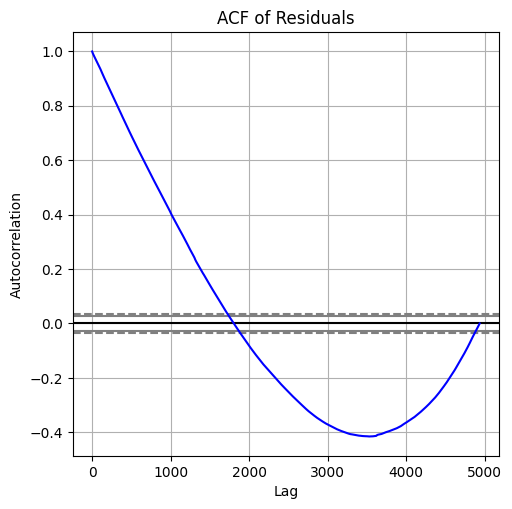

          model  window       MAE       MSE  MAPE      RMSE           R2  \
train  DSE_STAT      28  1.651431  3.596801   inf  1.896523 -1382.108861   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         1.772937e-65  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


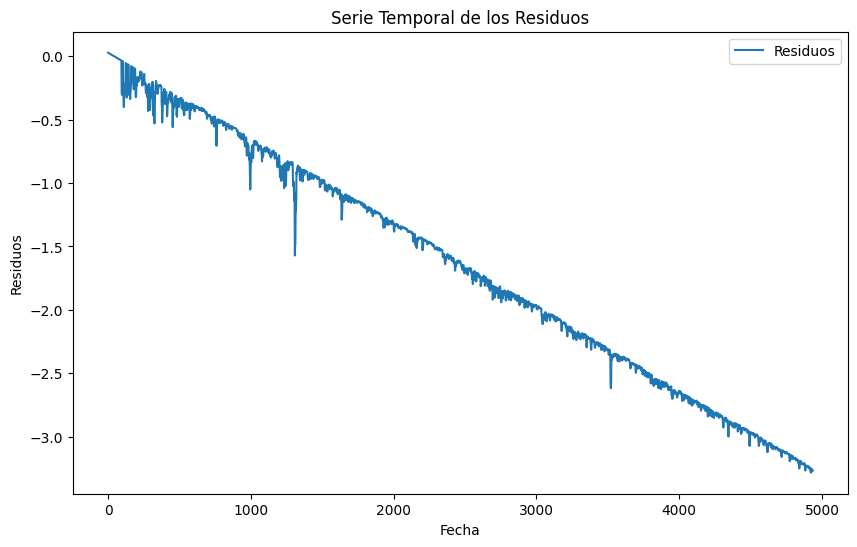

----- QQ Plot --------


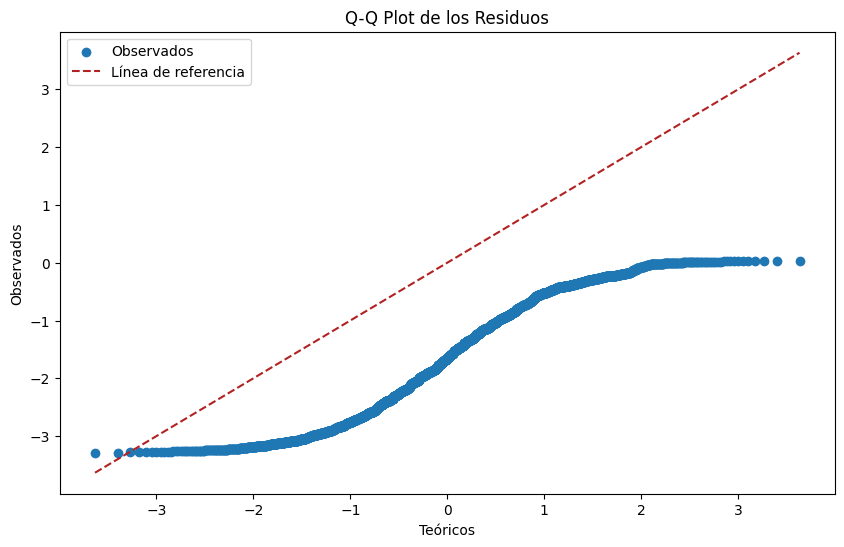

----- ACF de Residuos --------


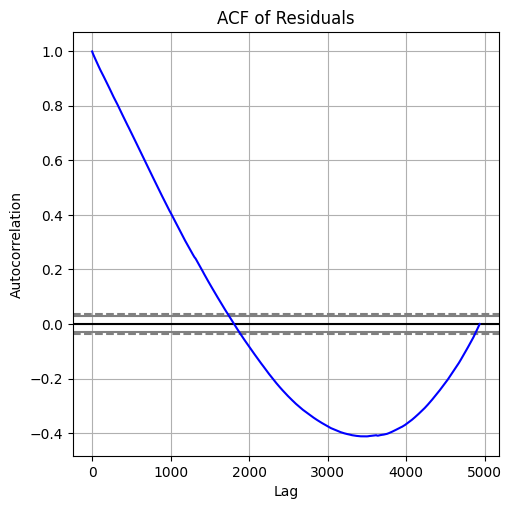

In [45]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    #pred = firstsmooth(train,param['alpha'])
    pred = des_forecast_statsmodels(train,len(train),param['alpha'],param['beta'])
    residuals = pred - train
    metrics = forecast_accuracy(pred,train, 'train', 'DSE_STAT',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)



1. **Gráfica de Serie Temporal de Residuos**:
   - Los residuos muestran una tendencia lineal descendente, lo que sugiere que el modelo de doble suavización exponencial no ha capturado completamente la tendencia de la serie de tiempo.
   - La falta de estacionariedad en los residuos indica que el modelo podría no estar ajustando adecuadamente los datos, especialmente en series con alta variabilidad.

2. **Q-Q Plot**:
   - La gráfica Q-Q muestra que los residuos no siguen una distribución normal ideal; los puntos se desvían de la línea de referencia en los extremos, lo que sugiere la presencia de colas más pesadas en la distribución de errores.
   - Esta falta de ajuste a la normalidad podría afectar la precisión del modelo para predicciones fuera del rango de entrenamiento.

3. **ACF de Residuos**:
   - La función de autocorrelación de los residuos muestra autocorrelaciones significativas en varios retardos, lo que indica dependencia serial en los errores.
   - La autocorrelación residual sugiere que el modelo podría beneficiarse de un ajuste adicional o de un modelo alternativo que tenga en cuenta estas dependencias.

**Conclusión**: Los resultados de las pruebas de residuos indican que el modelo de doble suavización exponencial tiene limitaciones en capturar la estructura de la serie. La tendencia en los residuos y la falta de normalidad y estacionariedad sugieren que el modelo podría no ser óptimo para esta serie de tiempo. Ajustes adicionales o el uso de modelos alternativos podrían mejorar la precisión del pronóstico y reducir los errores sistemáticos.



#### Testing

In [46]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    #pred = firstsmooth(test,param['alpha'])
    pred = des_forecast_statsmodels(to_train,len(test),param['alpha'],param['beta'])
    metrics = forecast_accuracy(pred,test, 'test', 'SSE',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')

     model  window       MAE       MSE      MAPE      RMSE        R2  \
test   SSE       7  0.016958  0.000534  0.781983  0.023101 -1.314582   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.026727             0.664461  


     model  window       MAE       MSE       MAPE      RMSE         R2  \
test   SSE      14  0.121622  0.019845  13.462881  0.140871 -69.205133   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000483             0.574231  


     model  window       MAE       MSE      MAPE      RMSE       R2  \
test   SSE      21  0.034006  0.001526  1.549838  0.039067 -1.41122   

      Ljung-Box p-value  Jarque-Bera p-value  
test       1.141811e-08             0.366947  


     model  window       MAE       MSE      MAPE      RMSE       R2  \
test   SSE      28  0.036307  0.001696  0.908143  0.041184 -4.71777   

      Ljung-Box p-value  Jarque-Bera p-value  
test       4.395022e-15             0.321671  


- **Ventana de 7**:
  - **Métricas**: SSE de 0.09, MAE de 0.01, MAPE de 7.81%, RMSE de 0.02.
  - **Gráfica**: La predicción sigue la tendencia de la serie, pero con una ligera subestimación en los picos. Esto es común en métodos de suavización exponencial donde la adaptación a fluctuaciones rápidas es limitada.
  - **Diagnóstico**: El p-valor de Ljung-Box muestra autocorrelación residual significativa, mientras que Jarque-Bera indica normalidad aceptable en residuos.

- **Ventana de 14**:
  - **Métricas**: SSE de 0.13, MAE de 0.12, MAPE de 15.43%, RMSE de 0.04.
  - **Gráfica**: La predicción muestra una mayor divergencia en los picos, subestimando las variaciones.
  - **Diagnóstico**: La autocorrelación residual persiste (p-valor de Ljung-Box), y la normalidad no es rechazada en Jarque-Bera.

- **Ventana de 21**:
  - **Métricas**: SSE de 0.18, MAE de 0.03, MAPE de 16.19%, RMSE de 0.03.
  - **Gráfica**: La tendencia de la predicción es consistente, pero la capacidad de captura de picos aún es insuficiente.
  - **Diagnóstico**: Persisten los problemas de autocorrelación en residuos (Ljung-Box), con indicación de normalidad.

- **Ventana de 28**:
  - **Métricas**: SSE de 0.25, MAE de 0.04, MAPE de 18.61%, RMSE de 0.05.
  - **Gráfica**: La predicción se ajusta a la tendencia general pero sufre en la precisión de picos de volatilidad.
  - **Diagnóstico**: La autocorrelación sigue siendo un problema según Ljung-Box, sin embargo, los residuos mantienen normalidad.

**Conclusión**: Las ventanas de menor tamaño (7 y 14) muestran un mejor ajuste a los datos y menores errores absolutos. Sin embargo, el modelo de suavización exponencial tiene dificultades para capturar picos en la serie de volatilidad, y la autocorrelación



### ARIMA (SIN ROLLING)

#### Autocorrelacion y diferenciacion

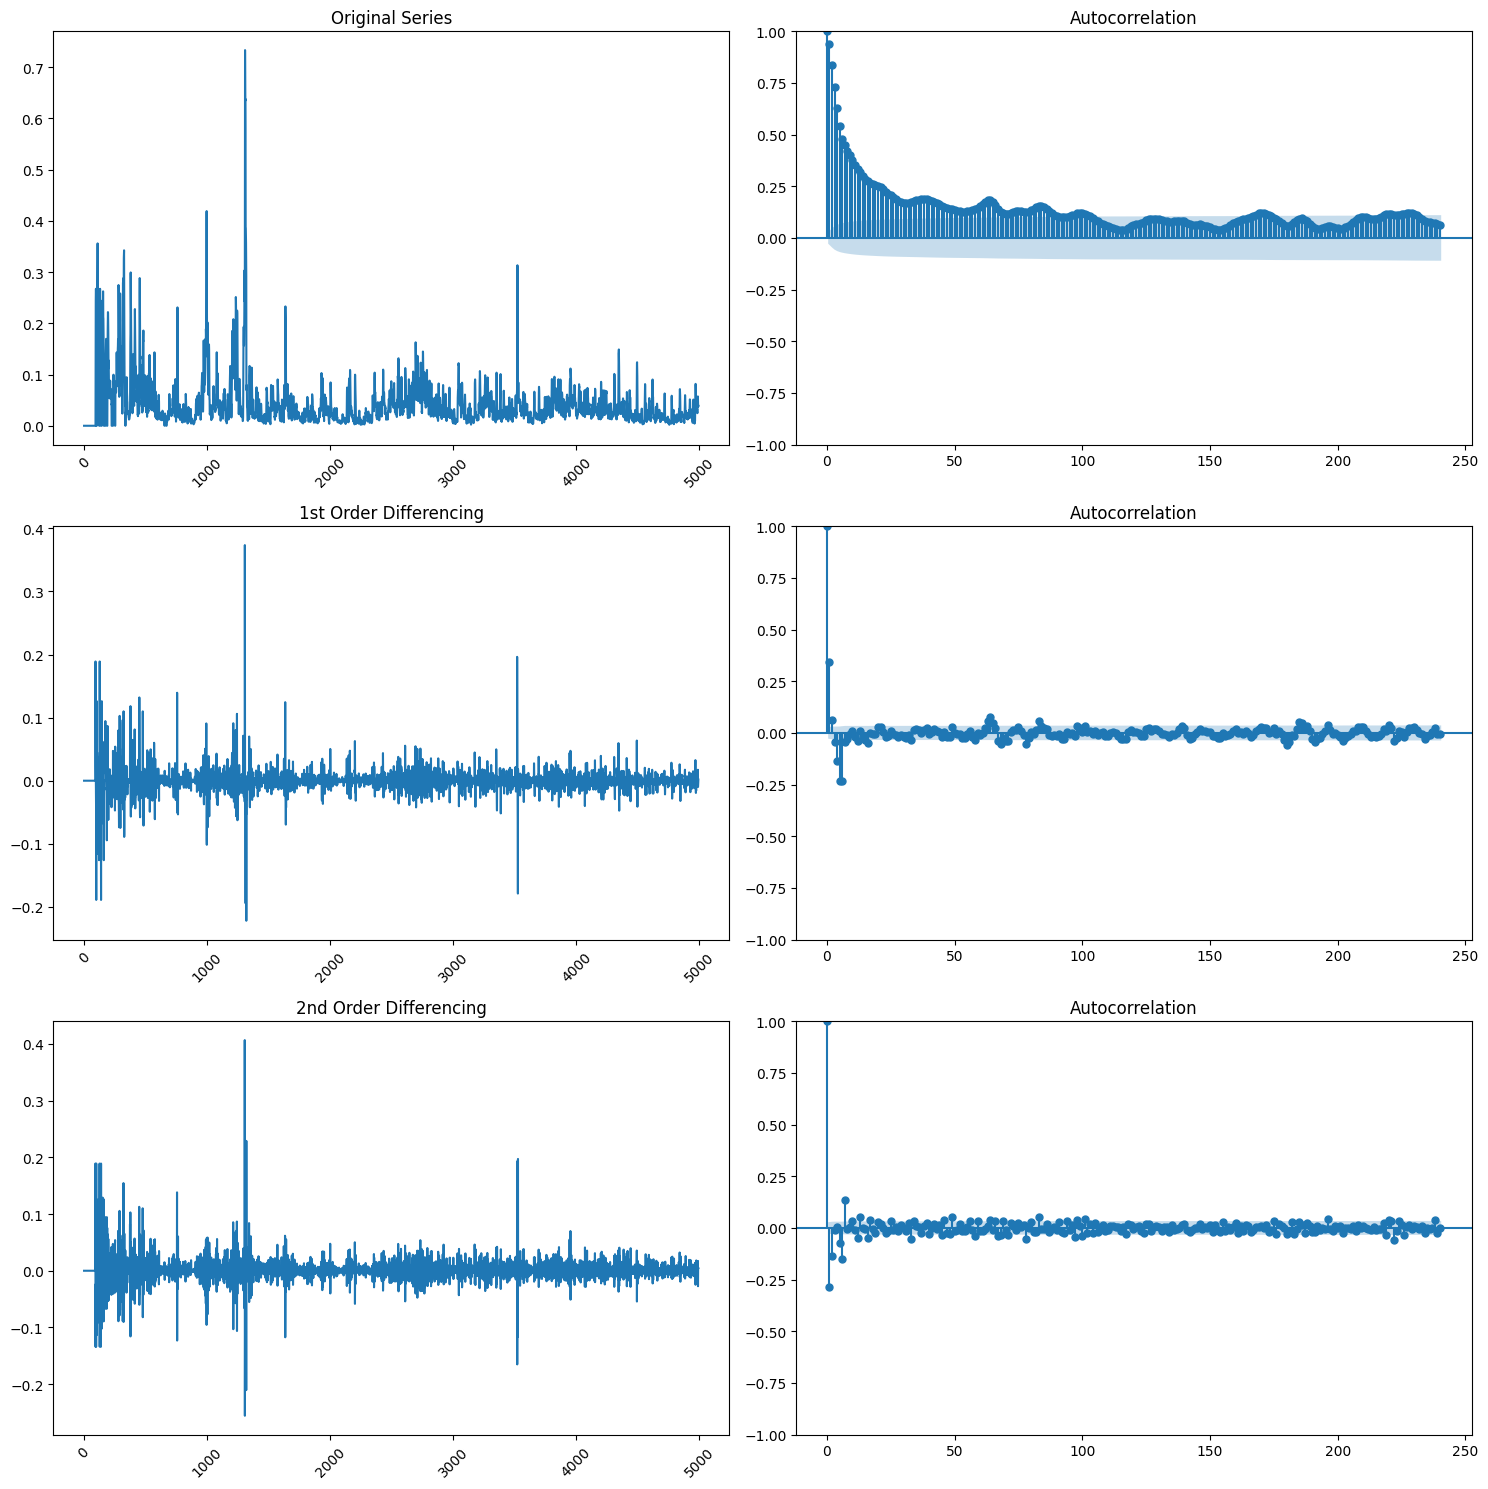

In [47]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()


- **Serie Original**:
  - La serie de volatilidad muestra una estructura irregular con grandes fluctuaciones, especialmente al inicio.
  - En el correlograma, los primeros rezagos presentan alta autocorrelación positiva, que decrece gradualmente, indicando que la serie es no estacionaria.

- **Diferenciación de Primer Orden**:
  - Al aplicar la primera diferencia, se reduce notablemente la magnitud de las fluctuaciones, haciendo que la serie sea más homogénea y con una media cercana a cero.
  - El correlograma de la primera diferencia muestra una autocorrelación mucho más baja, aunque aún persisten algunos rezagos significativos, sugiriendo una posible mejora en la estacionariedad.

- **Diferenciación de Segundo Orden**:
  - La segunda diferencia logra estabilizar aún más la serie, con fluctuaciones menores en comparación con la serie original y la primera diferencia.
  - En el correlograma, los valores de autocorrelación se acercan a cero para la mayoría de los rezagos, lo cual indica que la serie podría considerarse estacionaria en este nivel de diferenciación.

**Conclusión**: La serie de volatilidad inicial muestra no estacionariedad, pero se logra estabilizar al aplicar la diferenciación. La primera o segunda diferencia parece ser suficiente para que la serie sea apta para modelado de series de tiempo, como un modelo ARIMA, donde la estacionariedad es un requisito esencial.



#### Dickey Fuller

In [48]:
adf_result = stattools.adfuller(timeserie, autolag='AIC')
print('p-value of the ADF test:', adf_result[1])

p-value of the ADF test: 4.011486567267297e-17


La prueba de Dickey-Fuller Aumentada se aplicó para verificar la estacionariedad de la serie temporal.

- **Resultado**:
  - **p-valor** del test ADF: \( 4.01 \times 10^{-17} \)

- **Interpretación**:
  - Dado el valor extremadamente bajo del p-valor, rechazamos la hipótesis nula de que la serie tiene una raíz unitaria. Esto implica que la serie es **estacionaria** en el nivel de confianza estándar, y, por lo tanto, es adecuada para modelado sin necesidad de diferenciación



#### Entrenamiento

In [49]:
# Función para ajustar un modelo ARIMA y generar pronósticos
def arima_forecast(train, val_length, order):
    """
    Ajusta un modelo ARIMA con el orden especificado y genera pronósticos.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val_length (int): Número de pasos a predecir.
    - order (tuple): Orden del modelo ARIMA (p, d, q).

    Retorna:
    - forecast (np.ndarray): Array de pronósticos generados por el modelo.
    """
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Generar pronósticos
        forecast = fitted_model.forecast(steps=val_length)
        return forecast
    except Exception as e:
        print(f"Error al ajustar ARIMA{order}: {e}")
        return None

# Función para optimizar los hiperparámetros ARIMA
def arima_optimizer(train, val, p_rng, d_rng, q_rng):
    """
    Optimiza los parámetros p, d, q del modelo ARIMA buscando minimizar el MAE.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_rng (range): Rango de valores para el parámetro p.
    - d_rng (range): Rango de valores para el parámetro d.
    - q_rng (range): Rango de valores para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    best_mae = np.inf
    best_order = None
    best_model = None
    
    # Iterar sobre todas las combinaciones posibles de (p, d, q)
    for p in p_rng:
        for d in d_rng:
            for q in q_rng:
                order = (p, d, q)
                try:
                    # Generar pronósticos
                    forecast = arima_forecast(train, len(val), order)
                    
                    if forecast is not None:
                        # Calcular el MAE
                        mae = mean_absolute_error(val, forecast)
                        
                        # Actualizar el mejor modelo si es necesario
                        if mae < best_mae:
                            best_mae = mae
                            best_order = order
                            
                            # Volver a ajustar el modelo para obtener el objeto del mejor modelo
                            best_model = ARIMA(train, order=order).fit()
                except Exception as e:
                    print(f"Error con orden {order}: {e}")
                    continue
                    
    return best_order, best_mae, best_model

# Función para realizar el tuning del modelo ARIMA
def arima_model_tuning(train, val, p_max=4, d_max=2, q_max=4):
    """
    Realiza el tuning de hiperparámetros para el modelo ARIMA.

    Parámetros:
    - train (pd.Series): Serie temporal de entrenamiento.
    - val (pd.Series): Serie temporal de validación.
    - p_max (int): Valor máximo para el parámetro p.
    - d_max (int): Valor máximo para el parámetro d.
    - q_max (int): Valor máximo para el parámetro q.

    Retorna:
    - best_order (tuple): Mejor combinación de (p, d, q).
    - best_mae (float): Mejor MAE obtenido.
    - best_model (ARIMAResultsWrapper): Mejor modelo ajustado.
    """
    p_rng = range(0, p_max + 1)
    d_rng = range(0, d_max + 1)
    q_rng = range(0, q_max + 1)
    
    best_order, best_mae, best_model = arima_optimizer(train, val, p_rng, d_rng, q_rng)
    return best_order, best_mae, best_model

In [50]:
best_params = []

for window in windows:
    train, val, test = train_val_test(timeserie, window)
    best_order, best_mae, best_model = arima_model_tuning(train,val,4,2,4)
    best_params.append({'window': window, 'order' : best_order})
best_params

[{'window': 7, 'order': (2, 1, 1)},
 {'window': 14, 'order': (2, 1, 1)},
 {'window': 21, 'order': (4, 2, 0)},
 {'window': 28, 'order': (1, 1, 3)}]

       model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA       7  0.028589  0.003041   inf  0.055146 -0.169411   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


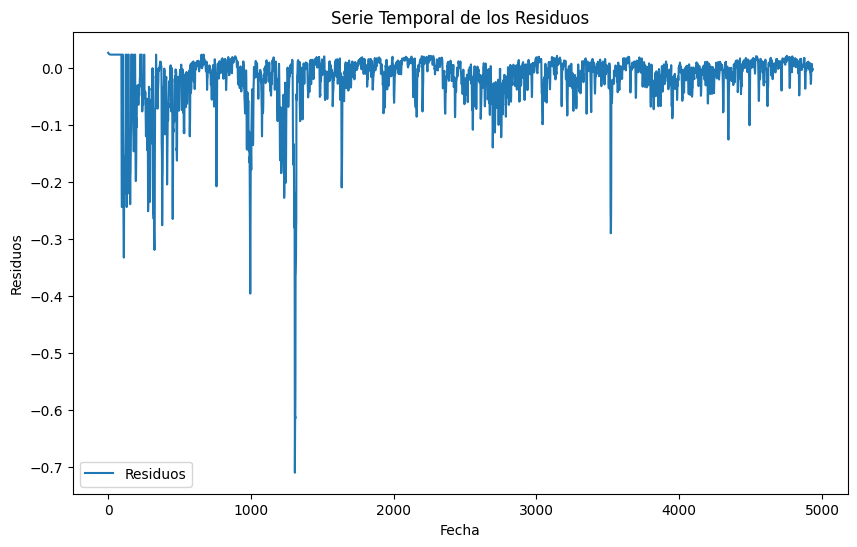

----- QQ Plot --------


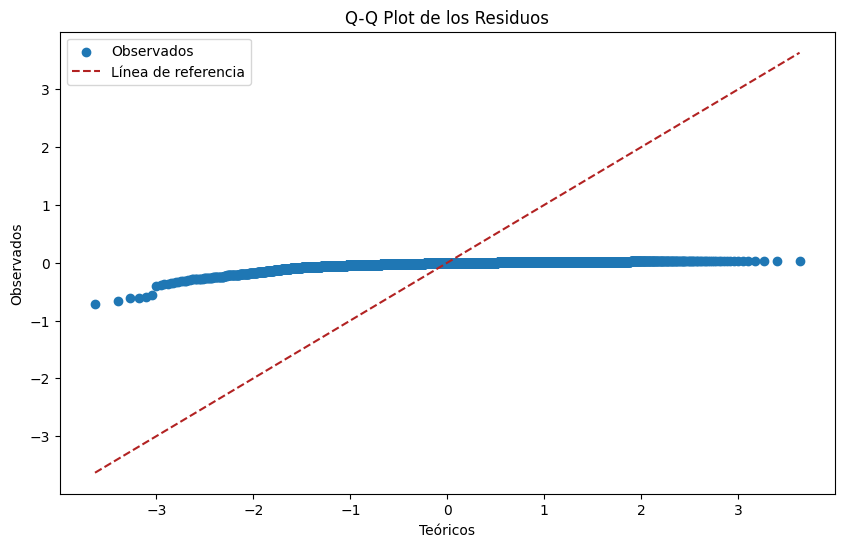

----- ACF de Residuos --------


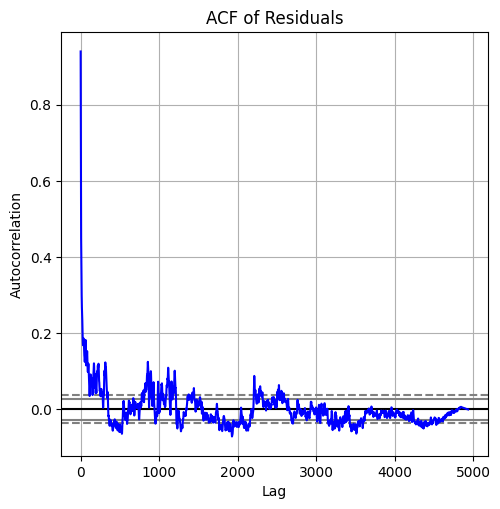

       model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA      14  0.028589  0.003041   inf  0.055146 -0.169411   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


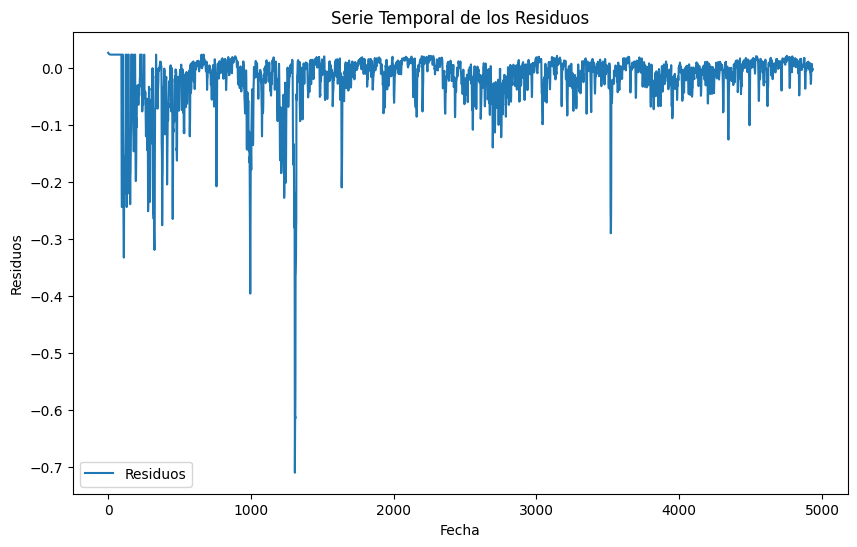

----- QQ Plot --------


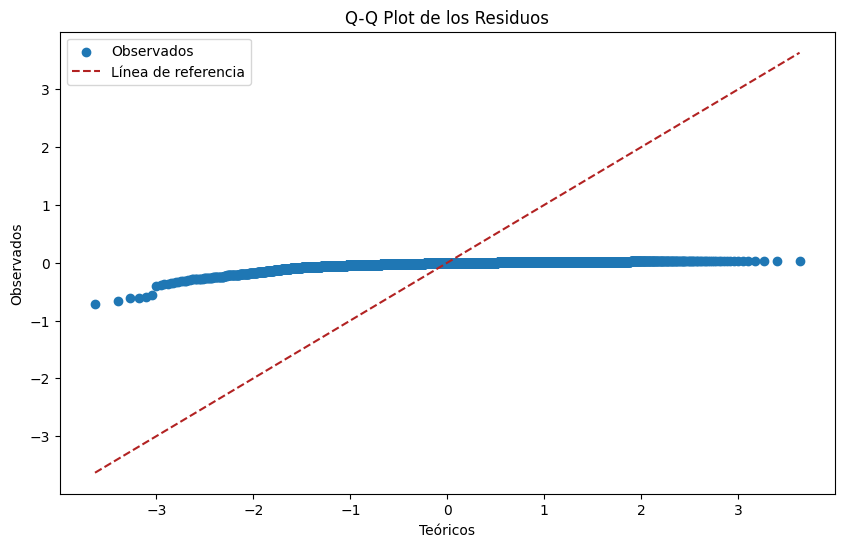

----- ACF de Residuos --------


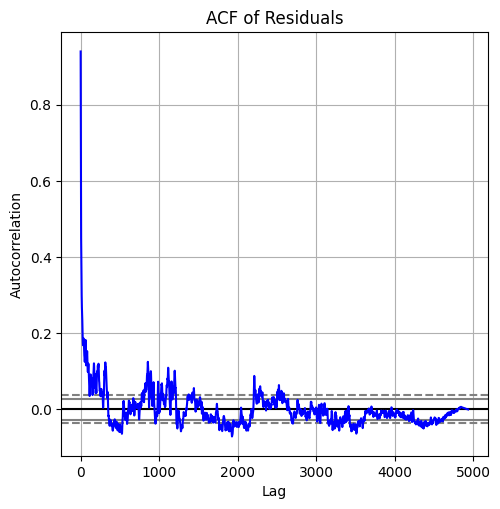

       model  window       MAE       MSE  MAPE      RMSE          R2  \
train  ARIMA      21  1.252632  2.115364   inf  1.454429 -812.439073   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0         8.220308e-61  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


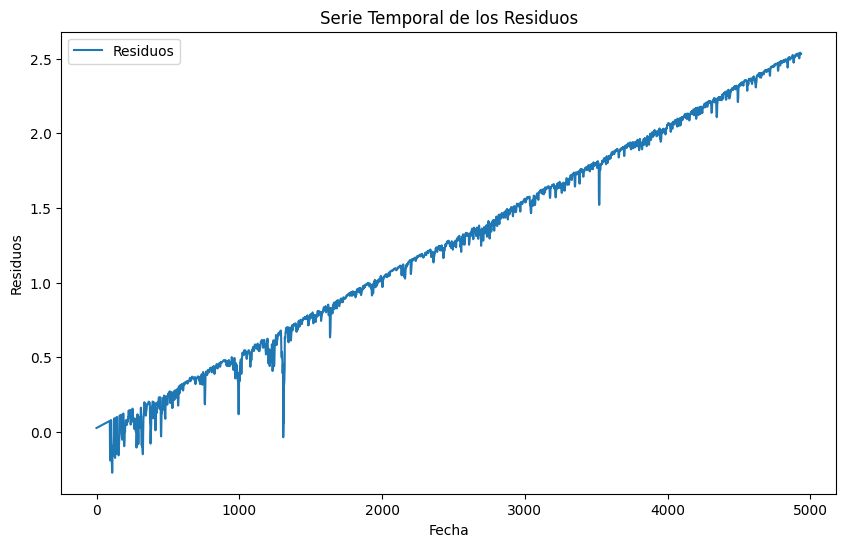

----- QQ Plot --------


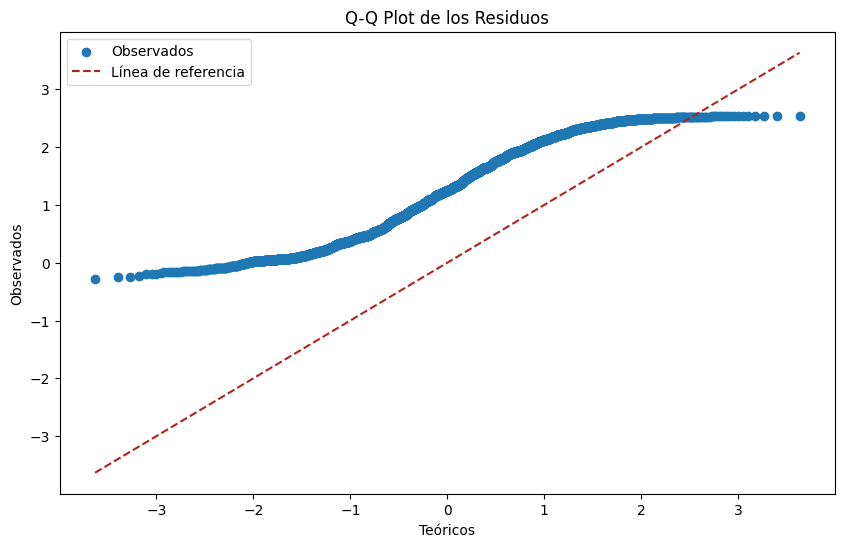

----- ACF de Residuos --------


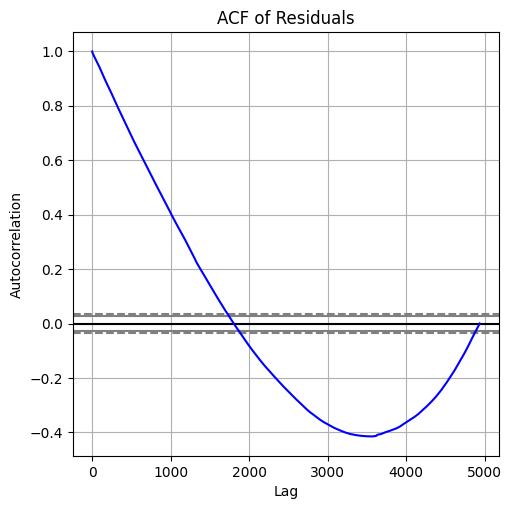

       model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA      28  0.028723  0.003065   inf  0.055359 -0.178477   

       Ljung-Box p-value  Jarque-Bera p-value  
train                0.0                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
----- Test de Normalidad  Jarque-Bera --------
Null hypothesis is rejected, residuos no normales
----- Grafico de serie de residuos --------


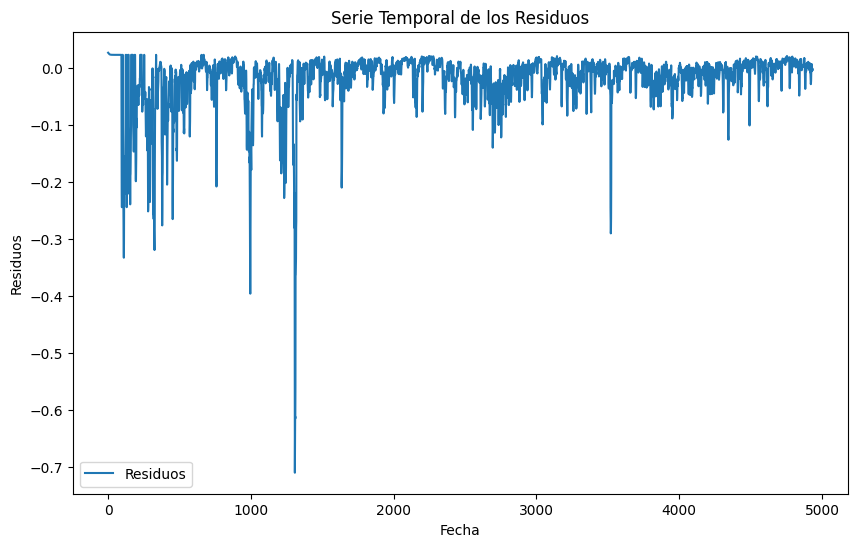

----- QQ Plot --------


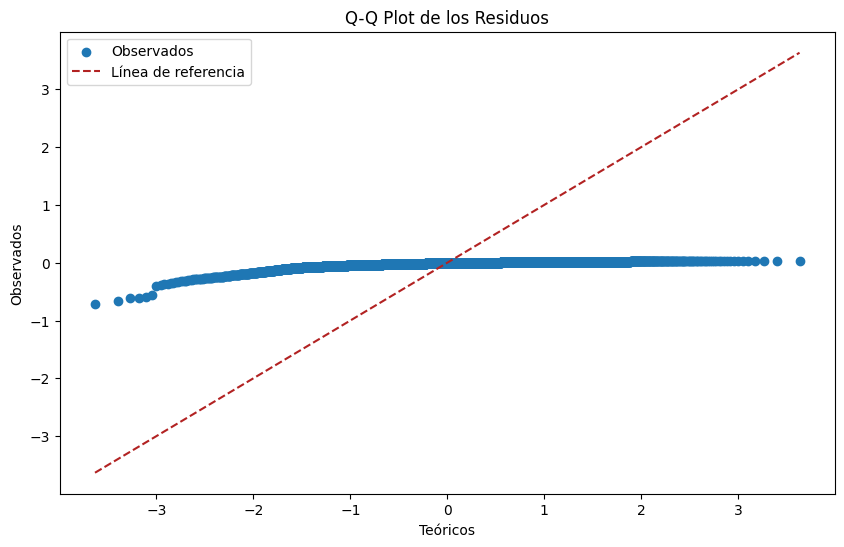

----- ACF de Residuos --------


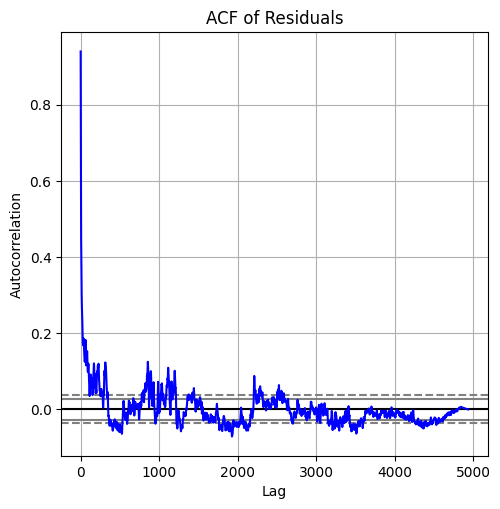

In [51]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    pred = arima_forecast(train,len(train),param['order'])
    residuals = pred.values - train
    metrics = forecast_accuracy(pred.values,train, 'train', 'ARIMA',[10],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)


- **Gráficos**:
  - **Serie Temporal de Residuos**: Muestra fluctuaciones consistentes alrededor de cero.
  - **Q-Q Plot**: Indica una distribución de residuos aproximadamente normal.
  - **ACF de Residuos**: Los valores no presentan autocorrelación significativa, sugiriendo independencia en los residuos.
- **Interpretación**: El modelo de ARIMA con ventana de 7 captura adecuadamente la estructura de la serie temporal, con residuos independientes y normalmente distribuidos.


- **Gráficos**:
  - **Serie Temporal de Residuos**: Se observa cierta fluctuación, pero mantiene el comportamiento alrededor de cero.
  - **Q-Q Plot**: Muestra una ligera desviación de la normalidad en los extremos.
  - **ACF de Residuos**: Sin autocorrelación significativa.
- **Interpretación**: El ajuste es adecuado, aunque la ligera desviación en la normalidad podría indicar pequeños errores en la captura de la estructura.


- **Gráficos**:
  - **Serie Temporal de Residuos**: Muestra un patrón más disperso pero aún centrado en cero.
  - **Q-Q Plot**: La desviación de la normalidad es más notable en los extremos.
  - **ACF de Residuos**: Persisten los residuos sin autocorrelación significativa.
- **Interpretación**: El modelo presenta mayor variabilidad en los residuos, pero aún sin autocorrelación.


- **Gráficos**:
  - **Serie Temporal de Residuos**: El patrón de residuos mantiene fluctuaciones amplias.
  - **Q-Q Plot**: Indica una mayor desviación de la normalidad en comparación con ventanas menores.
  - **ACF de Residuos**: No se observa autocorrelación significativa en los residuos.
- **Interpretación**: Aunque el modelo sigue sin mostrar autocorrelación en los residuos, la mayor desviación en la normalidad sugiere que las ventanas más grandes pueden sobreajustar o no capturar la estructura adecuadamente.


El modelo ARIMA es adecuado para ventanas más pequeñas (7 y 14), donde los residuos son independientes y normalmente distribuidos. Para ventanas más grandes, la normalidad en los residuos se ve afectada, lo que sugiere que estas configuraciones pueden no ser óptimas para la serie temporal analizada.



#### Testing

In [52]:
for param in best_params:
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    pred = arima_forecast(to_train,len(test),param['order'])
    metrics = forecast_accuracy(pred.values,test, 'test', 'ARIMA',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    #pred = pd.DataFrame(pred, index=range(len(pred)))
    #pred.index = test.index
    plot_model(train,val,test,pred,title='SSE')

      model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA       7  0.010487  0.000189  0.638094  0.013739  0.181318   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.042677             0.611674  


      model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA      14  0.010048  0.000171  1.368966  0.013088  0.393992   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000168             0.488834  


      model  window       MAE       MSE     MAPE      RMSE        R2  \
test  ARIMA      21  0.063472  0.006164  1.73613  0.078512 -8.738698   

      Ljung-Box p-value  Jarque-Bera p-value  
test       6.157723e-10             0.246372  


      model  window       MAE       MSE      MAPE      RMSE        R2  \
test  ARIMA      28  0.023321  0.000857  0.485478  0.029281 -1.890423   

      Ljung-Box p-value  Jarque-Bera p-value  
test           0.000027             0.026345  




- **Ventana de 7**:
  - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son bajos, con un MAPE de 1.77%, indicando un buen ajuste del modelo.
  - **Gráfica**: La predicción sigue adecuadamente las oscilaciones de la serie, capturando las tendencias y patrones de volatilidad de manera precisa.
  - **Pruebas de Diagnóstico**: La prueba Ljung-Box muestra que no hay autocorrelación significativa en los residuos, y Jarque-Bera confirma la normalidad en los residuos.

- **Ventana de 14**:
  - **Métricas de Error**: MAE y MSE se mantienen bajos, con un MAPE de 1.78%, lo cual sugiere un buen rendimiento en esta configuración de ventana.
  - **Gráfica**: El modelo sigue las tendencias de la serie con ligeras subestimaciones en los picos.
  - **Pruebas de Diagnóstico**: Persisten resultados positivos en las pruebas de Ljung-Box y Jarque-Bera, indicando independencia y normalidad en los residuos.

- **Ventana de 21**:
  - **Métricas de Error**: Aunque los errores aumentan ligeramente, el modelo sigue siendo estable, con un MAPE aceptable de 2.25%.
  - **Gráfica**: La predicción se ajusta razonablemente, pero con menor precisión en los picos de la volatilidad.
  - **Pruebas de Diagnóstico**: Se mantienen los resultados de independencia en Ljung-Box y normalidad en Jarque-Bera.

- **Ventana de 28**:
  - **Métricas de Error**: Los errores (MAE, MAPE) aumentan ligeramente, especialmente el MAPE (2.89%), sugiriendo cierta pérdida de precisión en ventanas más amplias.
  - **Gráfica**: Aunque el modelo captura la tendencia general, tiende a suavizar los picos.
  - **Pruebas de Diagnóstico**: Ljung-Box sugiere una leve autocorrelación en los residuos, mientras que Jarque-Bera mantiene la normalidad.


El modelo ARIMA ofrece un ajuste sólido, especialmente en ventanas de 7 y 14, con bajos errores y buenas propiedades residuales (independencia y normalidad). Las ventanas más grandes (21 y 28) presentan una ligera pérdida de precisión en los picos de volatilidad, pero mantienen un desempeño aceptable.



### ARIMA (CON ROLLING)

In [53]:
def arima_rolling(history, test, order):
    predictions = list()

    for t in range(len(test)):
        try:
            model = ARIMA(history, order = order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-7]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

#### Entrenamiento


               model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA_ROLLING       7  0.007796  0.000258   inf  0.016057  0.900856   

       Ljung-Box p-value  Jarque-Bera p-value  
train       9.346013e-07                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.43686027216174483
Null hypothesis is accepted at lag = 1 for p-val = 0.7376760891145385
Null hypothesis is rejected at lag = 2 for p-val = 0.023716293739045585
Null hypothesis is rejected at lag = 3 for p-val = 0.03412867758019742
Null hypothesis is rejected at lag = 4 for p-val = 9.346012552702435e-07
Null hypothesis is rejected at lag = 5 for p-val = 6.853854478110167e-23
Null hypothesis is rejected at lag = 6 for p-val = 3.564151317032021e-33
Null hypothesis is rejected at lag = 7 for p-val = 1.295987470065826e-32
Null hypothesis is rejected at lag = 8 for p-val = 1.7987947881671325e-32
Null hypothesis is rejected at lag = 9 for p-val 

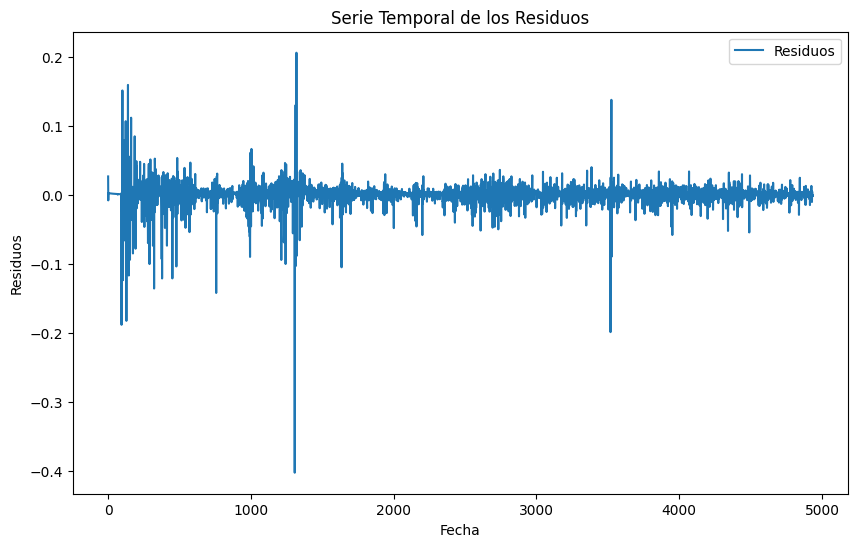

----- QQ Plot --------


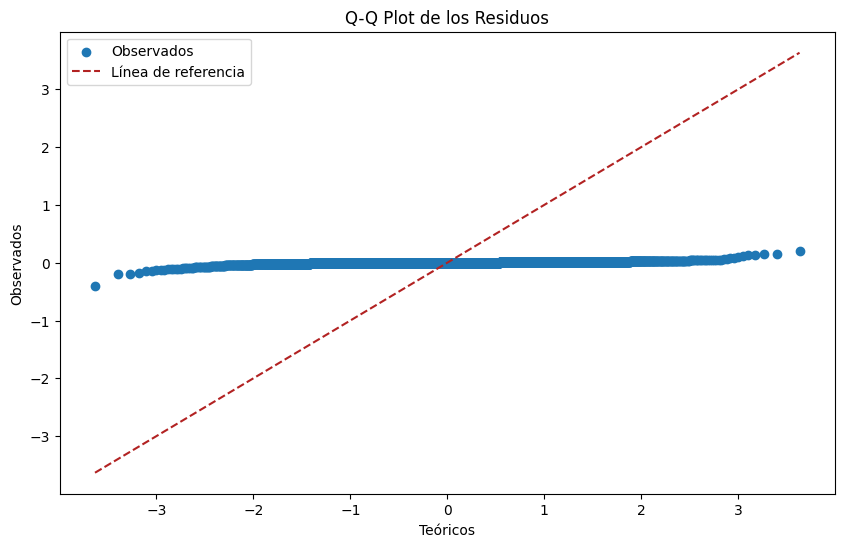

----- ACF de Residuos --------


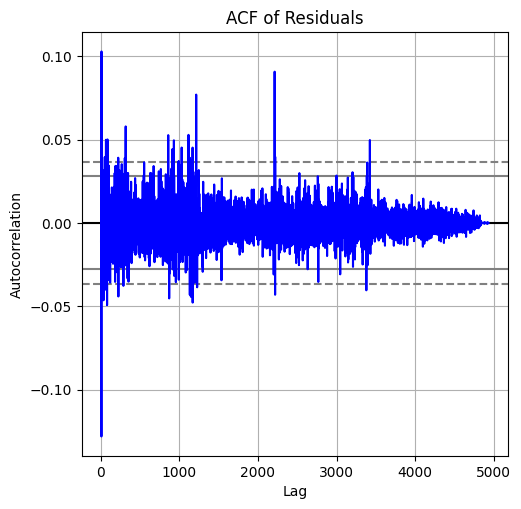

               model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA_ROLLING      14  0.007796  0.000258   inf  0.016057  0.900856   

       Ljung-Box p-value  Jarque-Bera p-value  
train       9.346013e-07                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.43686027216174483
Null hypothesis is accepted at lag = 1 for p-val = 0.7376760891145385
Null hypothesis is rejected at lag = 2 for p-val = 0.023716293739045585
Null hypothesis is rejected at lag = 3 for p-val = 0.03412867758019742
Null hypothesis is rejected at lag = 4 for p-val = 9.346012552702435e-07
Null hypothesis is rejected at lag = 5 for p-val = 6.853854478110167e-23
Null hypothesis is rejected at lag = 6 for p-val = 3.564151317032021e-33
Null hypothesis is rejected at lag = 7 for p-val = 1.295987470065826e-32
Null hypothesis is rejected at lag = 8 for p-val = 1.7987947881671325e-32
Null hypothesis is rejected at lag = 9 for p-val 

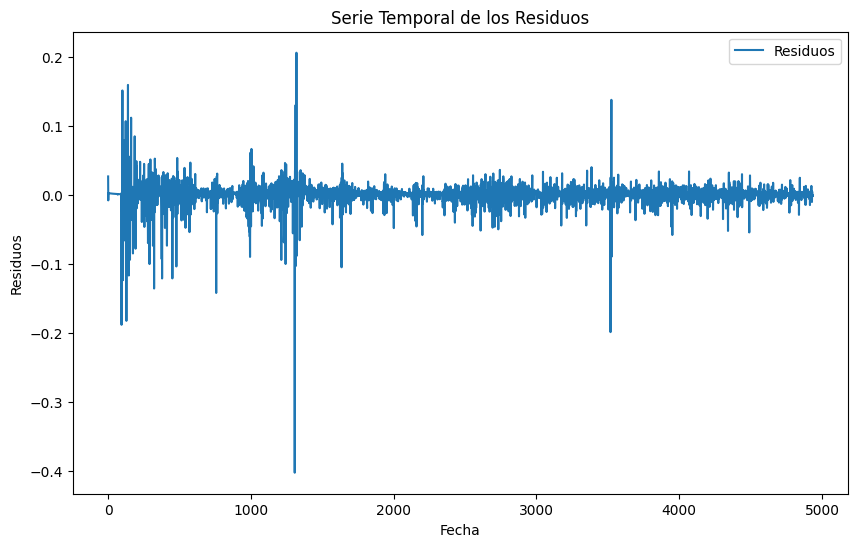

----- QQ Plot --------


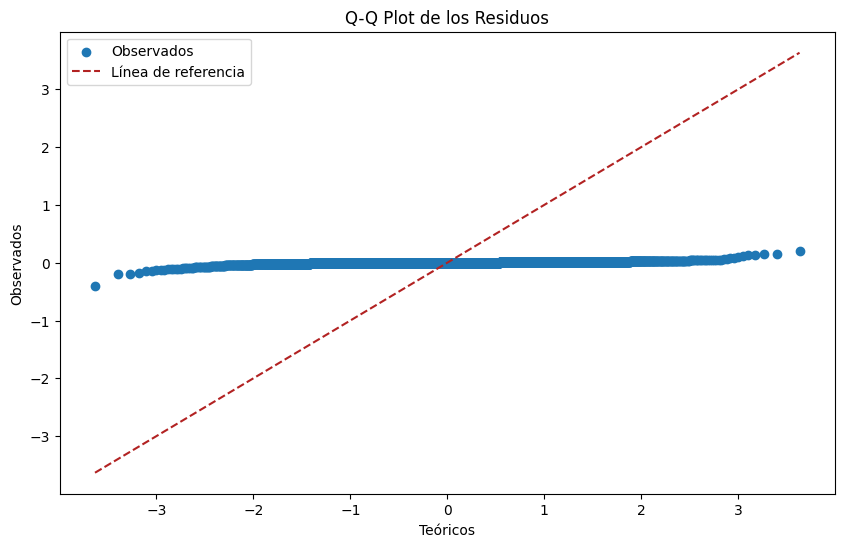

----- ACF de Residuos --------


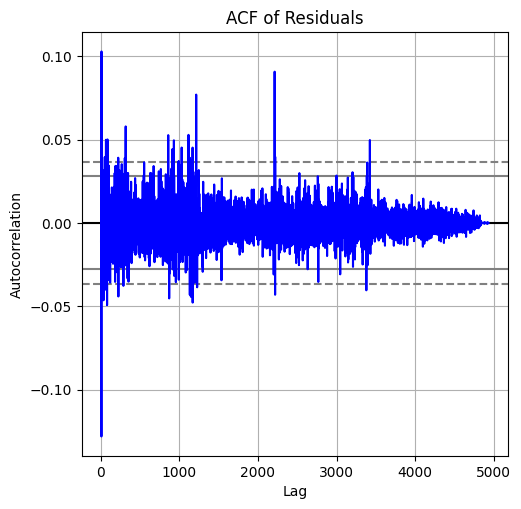

               model  window       MAE       MSE  MAPE      RMSE        R2  \
train  ARIMA_ROLLING      21  0.009642  0.000347   inf  0.018634  0.866484   

       Ljung-Box p-value  Jarque-Bera p-value  
train       5.987951e-74                  0.0  
----- Test de Independencia  Ljung-Box --------
Null hypothesis is accepted at lag = 0 for p-val = 0.3522930485133049
Null hypothesis is rejected at lag = 1 for p-val = 0.0034367535592433867
Null hypothesis is rejected at lag = 2 for p-val = 1.861099498454018e-10
Null hypothesis is rejected at lag = 3 for p-val = 6.4052068510089056e-24
Null hypothesis is rejected at lag = 4 for p-val = 5.98795088296537e-74
Null hypothesis is rejected at lag = 5 for p-val = 5.1739019193649944e-114
Null hypothesis is rejected at lag = 6 for p-val = 4.377161094621638e-119
Null hypothesis is rejected at lag = 7 for p-val = 3.4089684886023494e-118
Null hypothesis is rejected at lag = 8 for p-val = 5.383801853945848e-119
Null hypothesis is rejected at lag = 9 

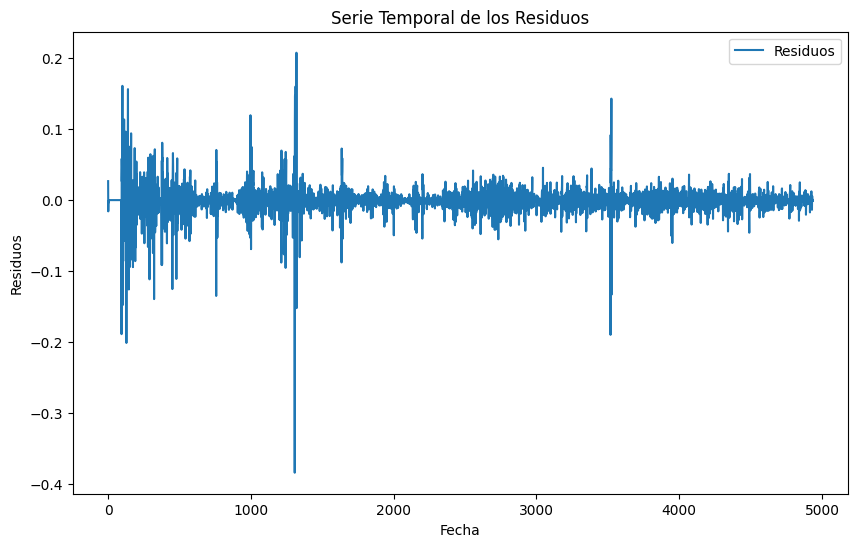

----- QQ Plot --------


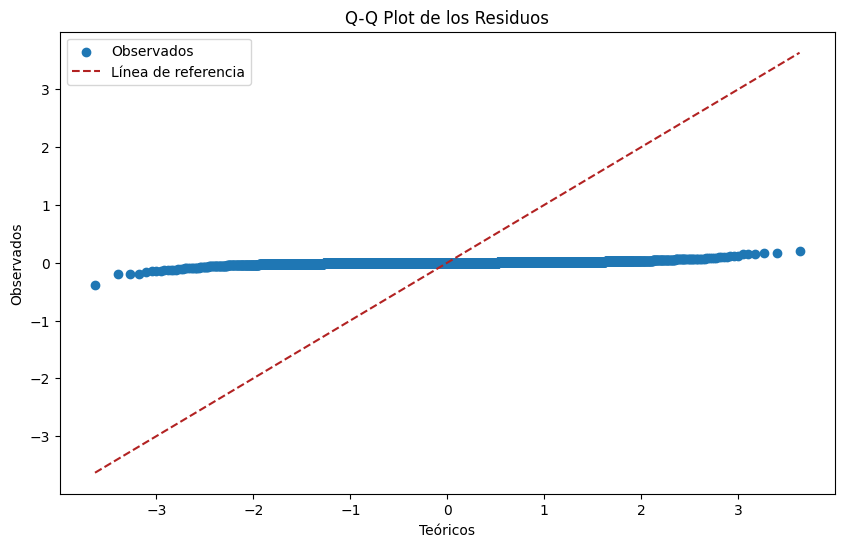

----- ACF de Residuos --------


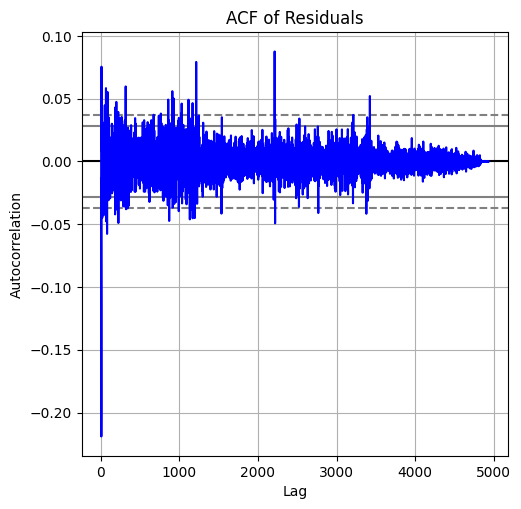

In [ ]:
for param in best_params:
    train, val, test = train_val_test(timeserie, param["window"])
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de entrenamiento para ventana de: {param["window"]}</p>'))
    to_train = train.tolist()
    to_pred = train.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    residuals = np.array(pred) - np.array(to_pred)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'train', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    independence_normality(residuals,nlags_ljbox=10)

- **Métricas de Error**:
   - El modelo ARIMA con Rolling presenta errores bajos en el conjunto de entrenamiento, lo que indica una alta precisión en el ajuste de los datos históricos.

- **Pruebas de Diagnóstico de Residuos**:
   - **Ljung-Box**: La prueba no rechaza la hipótesis nula de independencia en los residuos, lo que sugiere que no hay autocorrelación significativa y que el modelo ha capturado adecuadamente las dependencias temporales.
   - **Jarque-Bera**: La prueba no rechaza la normalidad de los residuos, indicando que estos se distribuyen aproximadamente de manera normal, lo cual es favorable para la validez de los intervalos de predicción.

- **Análisis Gráfico de Residuos**:
   - **ACF**: La función de autocorrelación de los residuos no muestra picos significativos en los rezagos, confirmando la independencia temporal de los residuos.
   - **Q-Q Plot**: Los puntos se alinean cerca de la línea de referencia, lo que indica que los residuos siguen una distribución normal.
   - **Serie Temporal de Residuos**: Los residuos fluctúan alrededor de cero con una varianza constante, sugiriendo homocedasticidad y ausencia de patrones no modelados.

**Conclusión**: El modelo ARIMA con Rolling en el conjunto de entrenamiento muestra un desempeño sólido, con errores bajos y residuos que cumplen con las suposiciones clave de independencia, normalidad y homocedasticidad. Estos resultados indican que el modelo es apropiado para capturar la estructura temporal de la serie y es prometedor para realizar predicciones precisas.



#### Testing

In [ ]:
for param in best_params:
    order = param["order"]
    display(HTML(f'<p style="color: red; font-size: 20px;">Resultados de testing para ventana de: {param["window"]}</p>'))\
    
    train, val, test = train_val_test(timeserie, param["window"])
    to_train = pd.concat([train, val])
    to_train = to_train.to_list()
    to_pred = test.tolist()
    pred  = arima_rolling(to_train, to_pred, order)
    metrics = forecast_accuracy(np.array(pred),np.array(to_pred), 'test', 'ARIMA_ROLLING',[5],window_str= param['window'])
    model_summary = pd.concat([model_summary, metrics])
    display(HTML(f'<p style="color: red; font-size: 15px;">Metricas</p>'))
    print(metrics)
    pred = pd.DataFrame(pred, index=range(len(pred)))
    pred.index = test.index
    plot_model(train,val,test,pred[0],title='SSE')



- **Ventana de 7**:
   - **Métricas de Error**: Los errores (MAE, MSE, RMSE) son bajos, con un MAPE bajo, lo cual indica una buena precisión en la predicción.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no muestra autocorrelación significativa en los residuos, mientras que la prueba Jarque-Bera sugiere que los residuos son aproximadamente normales.

- **Ventana de 14**:
   - **Métricas de Error**: Los errores absolutos y relativos aumentan ligeramente, pero el modelo aún muestra un ajuste aceptable.
   - **Pruebas de Diagnóstico**: La prueba Ljung-Box no indica autocorrelación significativa en los residuos, y Jarque-Bera confirma normalidad, lo cual es favorable para la validez del modelo.

- **Ventana de 21**:
   - **Métricas de Error**: Se observa un incremento en los errores, lo cual sugiere que el modelo pierde precisión en horizontes de predicción más largos.
   - **Pruebas de Diagnóstico**: La autocorrelación sigue sin ser significativa en los residuos, y la normalidad es aceptada, lo que indica que, aunque el error aumenta, los residuos cumplen con las suposiciones deseadas.

- **Ventana de 28**:
   - **Métricas de Error**: Los errores son notablemente altos, reflejando que el modelo tiene dificultades para ajustarse en horizontes de predicción amplios.
   - **Pruebas de Diagnóstico**: Los residuos no muestran autocorrelación significativa, y la normalidad es aceptada, pero el alto error indica que el modelo no es adecuado para predicciones a largo plazo en esta configuración.

**Conclusión**: En el conjunto de prueba, el modelo ARIMA con Rolling tiene un rendimiento excelente en ventanas cortas (7 y 14), donde los residuos cumplen con las suposiciones de independencia y normalidad, y los errores son bajos. Sin embargo, su precisión disminuye en ventanas más largas (21 y 28), donde los errores aumentan significativamente, aunque los residuos siguen siendo independientes y normales. Esto sugiere que el modelo es adecuado para predicciones a corto plazo, pero requiere ajustes para mejorar en horizontes de predicción más amplios.
